In [137]:
import pandas as pd
import numpy as np

In [138]:
### DEFINE BETA VALUES FOR VDF

vot_growth = 0.014

vot_growth_2 = 0.013 # 0.010

vot_growth_3 = 0.010

beta_vals = {} # TBD: compute values based on growth

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.13, 3.133, 3.283, 3.286], # [3.820, 3.823, 4.005, 4.009],
    2: [0.715, 0.708, 0.592, 0.708]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2025] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth) ** (2032-2025)

beta_vals[2032] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_2) ** (2040-2032)

beta_vals[2040] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_3) ** (2050-2040)

beta_vals[2050] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_3) ** (2060-2050)

beta_vals[2060] = beta_vals_aux.copy()

beta_vals

{2025:             1      2
 Period              
 AM      3.130  0.715
 MD      3.133  0.708
 PM      3.283  0.592
 NT      3.286  0.708,
 2032:                1      2
 Period                 
 AM      3.449928  0.715
 MD      3.453235  0.708
 PM      3.618567  0.592
 NT      3.621873  0.708,
 2040:                1      2
 Period                 
 AM      3.825477  0.715
 MD      3.829144  0.708
 PM      4.012473  0.592
 NT      4.016140  0.708,
 2050:                1      2
 Period                 
 AM      4.225706  0.715
 MD      4.229757  0.708
 PM      4.432267  0.592
 NT      4.436317  0.708,
 2060:                1      2
 Period                 
 AM      4.667809  0.715
 MD      4.672283  0.708
 PM      4.895980  0.592
 NT      4.900454  0.708}

In [139]:
### DEFINE LOOKUP TABLE FOR BONUS PER PERIOD

lookup_period_file = r"inputs/LookUp_Period.csv"

lookup_period = pd.read_csv(
    lookup_period_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Clip y reasignar
lookup_period = lookup_period*0

lookup_period

,Bonus/Mile,4 Periods
Period,,
Night,0.0,
AM-Early,0.0,
AM-Peak,0.0,
AM-Shoulder,0.0,
MD,0.0,
PM-Shoulder,0.0,
PM-Peak,0.0,
PM-Late,0.0,


In [140]:
### DEFINE SEGMENT PARAMETERS
# Default configuration for time periods in traffic data

# TBD: Correctly assess the hard_cap, how does the soft cap work?
# year_soft_cap = [3.6 / 2, 4.2 / 2, 5.15 / 2]

#year_soft_cap = [3.9 / 2, 3.9 / 2, 3.9 / 2]

#TBD: Make this automatically
period_template = [                 # (Period, Hours/Day, Peak/OP, 4Periods tag)
    ("Night",        7, "OP",   "NT"),
    ("AM-Early",     1, "OP",   "AM"),
    ("AM-Peak",      3, "Peak", "AM"),
    ("AM-Shoulder",  1, "OP",   "AM"),
    ("MD",           5, "OP",   "MD"),
    ("PM-Shoulder",  1, "OP",   "PM"),
    ("PM-Peak",      3, "Peak", "PM"),
    ("PM-Late",      3, "OP",   "PM"),
]

rows = []
years = [2025, 2032, 2040, 2050]

# Default time periods list (for reference)
default_time_periods = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

# Create the base scenario: hour -> time period mapping
# hour_to_period = {
#     0: "Night",
#     1: "Night",
#     2: "Night",
#     3: "Night",
#     4: "Night",
#     5: "AM-Early",
#     6: "AM-Peak",
#     7: "AM-Shoulder",
#     8: "AM-Shoulder",
#     9: "AM-Shoulder",
#     10: "MD",
#     11: "MD",
#     12: "MD",
#     13: "MD",
#     14: "PM-Shoulder",
#     15: "PM-Shoulder",
#     16: "PM-Peak",
#     17: "PM-Peak",
#     18: "PM-Late",
#     19: "PM-Late",
#     20: "PM-Late",
#     21: "PM-Late",
#     22: "PM-Late",
#     23: "Night"
# }

hour_to_period = {
    0: "Night",
    1: "Night",
    2: "Night",
    3: "Night",
    4: "Night",
    5: "Night",
    6: "AM-Early",
    7: "AM-Peak",
    8: "AM-Peak",
    9: "AM-Peak",
    10: "AM-Shoulder",
    11: "MD",
    12: "MD",
    13: "MD",
    14: "MD",
    15: "MD",
    16: "PM-Shoulder",
    17: "PM-Peak",
    18: "PM-Peak",
    19: "PM-Peak",
    20: "PM-Late",
    21: "PM-Late",
    22: "PM-Late",
    23: "Night"
}

# Define the segments and their parameters

awt_adt = 1.1 # Average weekday traffic (AWT) to average daily traffic (ADT) ratio
peak_factor = 1 # Peak factor for adjustment at peak hour traffic

hov_percentage = pd.DataFrame({
    'Year' : [2025,2032,2040,2050],
    'HOV percentage' : [0,0,0,0]
})

hov_percentage.set_index('Year', inplace=True)

"""
segment_groups = {
    "S1": ["17056956 - I-40 west of Arlington Ave"],
    "S2": ["17056930 - I-40 east of Spence Ln"],
    "S3": ["17056932 - I-24 south of Murfreesboro Pike", "17056947 - I-24 NB Off Ramp to I-40"],
    "S4": ["17056937 - I-24 north of Old Glenrose Ave"],
    "S5": ["17056951 - I-24 south of Briley Pkwy"],
    "S6": ["17056945 - I-24 north Haywood Ln", "17056952 - I-24 south of Haywood Ln"],
    "S7": ["17056946 - I-24 east of Bell Rd", "17056953 - I-24 south of Old Franklin Rd"],
    "S8": ["17056954 - I-24 southeast of Old Hickory Blvd", "17056936 - I-24 northwest of Sam Ridley Pkwy W"],
    "S9": ["17056955 - I-24 northwest of I-840", "17056935 - I-24 northwest of Rocky Fork Rd"],
    "S10": ["17056934 - I-24 east of I-840 WB(5-15)_counts"],
    "S11": ["I24 Inner Circle", "Intersection with I65"],
    "S12": ["Intersection with I65", "Separation with I65"],
    "S13": ["I-40 with Briley Pkwy", "I-40 with Harding Pl"],
    "S14": ["I-40 Harding Pl", "I-40 with Old Hickory Blvd"],
    "S15": ["I-24 Intersection with I-840" ,"I-24 at Fortress Blvd"],
    "S16": ["I-24 at Fortress Blvd", "I-24 at Hwy-96"],
    "S17": ["I-840 Intersection with I-24", "I-840 intersection with US-41"]
}

"""

# Define segment parameters base
seg_params = pd.DataFrame({
    'SegDir':   ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB","11NB","11SB","12NB","12SB","13NB","13SB","14NB","14SB","15NB","15SB","16NB","16SB","17NB","17SB","18NB","18SB"],
    'Length':   [1.3,1.3,1.3,1.3,0.5,0.5,1.6,1.6,2,2,3.6,3.6,2.9,2.9,3.8,3.8,3.4,3.4,4.5,4.5,2.4,2.4,2.5,2.5,2,2,4,4,2.6,2.6,2.6,2.6,2.1,2.1,0.3,0.3], # [1.3,1.3,1.3,1.3,0.5,0.5,1.6,1.6,2,2,3.6,3.6,2.9,2.9,3.8,3.8,3.4,3.4,4.5,4.5,2.8,2.8,2.5,2.5,2.6,2.6,3.3,3.3,2.6,2.6,2.6,2.6,2.1,2.1],
    'Inscope':   [0.94,0.94,1,1,1,1,1,1,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94] + [0.931,0.964]*2 + [0.961,0.977]*2 + [1]*6 + [1]*2, # [0.82,0.82,0.92,0.92,0.88,0.88,0.88,0.88,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8],  
    'Lanes_GP':  [4]*22 + [5]*2 + [5]*6 + [4]*2 + [3]*2 + [3]*2, #
    'Lanes_ML':  [2]*36, # Lanes_ML': [2,2,2,2,2,2,2,2,3,3,2,2,2,2], # Do test changing segment 5
    'CapPerLane_GP': [2000]*36,
    'CapPerLane_ML': [1800]*36,
    'Speed_GP':  [55]*6 + [65]*2 + [70]*12 + [60]*2 + [60]*2 + [55]*2 + [60]*2 + [70]*6 + [60]*2,
    'Speed_ML':  [55]*6 + [65]*2 + [70]*12 + [60]*2 + [60]*2 + [60]*2 + [60]*2 + [75]*6 + [60]*2, # [60]*6 + [70]*2 + [70]*12 + [70]*2 + [70]*2 + [65]*2 + [70]*2 + [70]*6,
    'Alpha_GP':  [1]*36,
    'Beta_GP':   [6]*36,
    'Alpha_ML':  [1.6]*36,
    'Beta_ML':   [6.3]*36,
    'Min_Toll_2016': [None]*36,
    'Max_Toll_2016': [None]*36,
    'LanesGP_AM_Peak': [5]*36,
    'LanesGP_PM_Peak': [5]*36,
})


seg_params.set_index('SegDir', inplace=True)

# Compute capacities as lanes * cap per lane
seg_params['Cap_GP'] = seg_params['Lanes_GP'] * seg_params['CapPerLane_GP']
seg_params['Cap_ML'] = seg_params['Lanes_ML'] * seg_params['CapPerLane_ML']

# Compute peak capacities as Alpha * base capacity
seg_params['CapGP_Peak'] = seg_params['Alpha_GP'] * seg_params['Cap_GP']
seg_params['CapML_Peak'] = seg_params['Alpha_ML'] * seg_params['Cap_ML']

# Optional: if you want integer capacities
seg_params[['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']] = seg_params[
    ['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']
].astype(int)

# Preview
seg_params

,Length,Inscope,Lanes_GP,Lanes_ML,CapPerLane_GP,CapPerLane_ML,Speed_GP,Speed_ML,Alpha_GP,Beta_GP,Alpha_ML,Beta_ML,Min_Toll_2016,Max_Toll_2016,LanesGP_AM_Peak,LanesGP_PM_Peak,Cap_GP,Cap_ML,CapGP_Peak,CapML_Peak
SegDir,,,,,,,,,,,,,,,,,,,,
1NB,1.3,0.940,4,2,2000,1800,55,55,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
1SB,1.3,0.940,4,2,2000,1800,55,55,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
2NB,1.3,1.000,4,2,2000,1800,55,55,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
2SB,1.3,1.000,4,2,2000,1800,55,55,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
3NB,0.5,1.000,4,2,2000,1800,55,55,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
3SB,0.5,1.000,4,2,2000,1800,55,55,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
4NB,1.6,1.000,4,2,2000,1800,65,65,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
4SB,1.6,1.000,4,2,2000,1800,65,65,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
5NB,2.0,0.940,4,2,2000,1800,70,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760


In [141]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD

# capacity_factors_data = {
#     "SegDir":       ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
#     "Night":        [1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.05, 1.00, 1.15, 1.00, 1.20, 0.50, 1.10, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Peak":      [0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 0.75, 1.00, 1.20, 1.00, 1.00, 0.50, 1.00, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Shoulder":  [1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 0.70, 0.90, 1.00, 1.00, 1.40, 0.70, 1.20, 0.85, 1.00, 1.00, 1.00, 1.00],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 0.85, 0.80, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Shoulder":  [1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 0.70, 0.80, 1.00, 0.60, 0.80, 1.00, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Peak":      [1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.10, 1.00, 0.60, 0.80, 1.00, 0.50, 0.70, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

# capacity_factors_data = {
#     "SegDir": ["10NB","10SB","9NB","9SB","8NB","8SB","7NB","7SB","6NB","6SB","5NB","5SB","4NB","4SB","3NB","3SB","2NB","2SB","1NB","1SB"],
#     "Night":        [1.00, 1.00, 1.00, 1.00, 1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [1.10, 0.75, 1.10, 0.75, 0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.35, 1.10, 1.05, 1.00, 1.05, 1.00, 1.05, 1.00],
#     "AM-Peak":      [1.00, 0.75, 1.00, 0.75, 0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 1.10, 1.20, 0.75, 1.00, 0.75, 1.00, 0.75, 1.00],
#     "AM-Shoulder":  [1.20, 0.85, 1.20, 0.85, 1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 1.20, 1.10, 0.70, 0.90, 0.70, 0.90, 0.70, 0.90],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 1.10, 1.00, 0.85, 0.80, 0.85, 0.80, 0.85, 0.80],
#     "PM-Shoulder":  [0.90, 1.00, 0.90, 1.00, 1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 1.10, 0.80, 0.70, 0.80, 0.70, 0.80, 0.70, 0.80],
#     "PM-Peak":      [0.85, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.00, 0.50, 1.00, 0.50, 0.60, 0.80, 0.60, 0.80, 0.60, 0.80],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

capacity_factors_file = 'inputs/capacity_factors_extensions.csv'

capacity_factors_data = pd.read_csv(capacity_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = capacity_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

df_cf = df_cf.clip(lower=0.4, upper=1.3)

df_cf.loc['Night', :] = 1

# Transpose matrix to make the calculation

cap_adj = df_cf * seg_params['Cap_GP']

df_cf

,10NB,10SB,11NB,11SB,12NB,12SB,13NB,13SB,14NB,14SB,...,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,,
AM-Early,1.300000,1.300000,0.923403,0.915160,1.206015,0.456605,1.000000,0.568243,0.849098,0.584968,...,1.300000,0.999870,1.183511,0.999376,0.999994,0.999986,1.017107,1.125713,1.020730,1.000098
AM-Peak,1.000000,1.000000,1.000000,0.735044,1.300000,0.556180,1.000000,1.000000,1.000000,1.000000,...,1.001961,1.000000,1.002838,1.000000,1.000000,1.000000,0.966200,1.000000,1.000000,1.000000
AM-Shoulder,1.000629,1.000000,1.008159,0.728145,1.260144,0.924406,1.000000,1.000000,1.114844,1.000000,...,1.000108,1.000000,1.000000,1.000000,1.000163,1.000290,1.000044,1.000764,1.000680,1.000780
MD,1.078460,1.300000,0.691899,0.781150,0.835849,0.787440,0.823887,0.919186,0.912413,1.000000,...,1.019958,0.973710,1.037893,1.113525,1.034642,1.132741,1.000167,1.049731,0.980208,1.103445
Night,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PM-Late,0.591799,0.716519,0.748425,0.903539,0.578312,1.179831,0.430536,0.507681,0.400000,0.538587,...,0.669994,0.632106,0.543515,0.652107,0.518949,0.660895,0.525885,0.591934,0.517884,0.590669
PM-Peak,1.000000,1.000000,1.000000,1.006633,0.820793,1.089173,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.001075,1.000000,1.000057,1.000000,1.000000,1.000000,1.000000
PM-Shoulder,1.000000,1.000627,0.897033,0.785557,1.150000,1.150000,1.000000,1.070211,1.000000,1.000000,...,1.000516,1.000000,1.000517,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [142]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
pce_factors_file = 'inputs/pce_factors_extensions.csv'

pce_factors_data = pd.read_csv(pce_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = pce_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

#Lower upper limit changed to 1.0
# Transpose matrix to make the calculation

pce_adj = df_cf

pce_adj

,10NB,10SB,11NB,11SB,12NB,12SB,13NB,13SB,14NB,14SB,...,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,,
AM-Early,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
AM-Peak,1.005464,1.004793,1.120487,1.15,1.000000,1.15,0.950000,1.015004,1.173213,1.031003,...,1.000000,1.002728,1.000000,1.002596,1.131692,1.000528,1.150000,1.003981,1.001948,1.001204
AM-Shoulder,1.000000,1.000267,1.000000,1.15,1.000000,1.15,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000327,1.000140,1.000191,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
MD,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Night,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PM-Late,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PM-Peak,1.005748,1.008373,1.077989,1.00,1.150000,1.00,1.196102,1.044354,1.060533,0.962942,...,1.015237,1.049020,1.014408,1.000000,1.023656,1.000000,1.038075,1.009896,1.048504,1.000724
PM-Shoulder,1.000055,1.000000,1.150000,1.15,1.039972,1.00,1.097067,1.000000,1.000000,1.000000,...,1.000000,1.076799,1.000000,1.000487,1.000181,1.000261,1.000308,1.000055,1.000243,1.000108


In [143]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppression_file = 'inputs/suppression_extensions.csv'

suppression_data = pd.read_csv(suppression_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_data

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Shoulder,1.02,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.05,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.05,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.02,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.05,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
PM-Late,0.95,0.954229,0.958476,0.962743,0.967029,0.971333,0.975657,0.98,0.984913,0.989850,...,1.132194,1.135481,1.138777,1.142083,1.145399,1.148724,1.152058,1.155403,1.158757,1.162121


In [144]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppressionextensions_file = 'inputs/suppression_extensions.csv'

suppression_extensions_data = pd.read_csv(suppressionextensions_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_extensions_data

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Shoulder,1.02,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.05,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.05,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.02,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.05,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
PM-Late,0.95,0.954229,0.958476,0.962743,0.967029,0.971333,0.975657,0.98,0.984913,0.989850,...,1.132194,1.135481,1.138777,1.142083,1.145399,1.148724,1.152058,1.155403,1.158757,1.162121


In [145]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppression_file = 'inputs/suppression_NB_extensions.csv'

suppression_data_NB = pd.read_csv(suppression_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_data_NB

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.07,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Late,0.95,0.954229,0.958476,0.962743,0.967029,0.971333,0.975657,0.98,0.984913,0.989850,...,1.132194,1.135481,1.138777,1.142083,1.145399,1.148724,1.152058,1.155403,1.158757,1.162121


In [146]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppression_file = 'inputs/suppression_SB_extensions.csv'

suppression_data_SB = pd.read_csv(suppression_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_data_SB

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
AM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.07,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
PM-Late,0.95,0.954229,0.958476,0.962743,0.967029,0.971333,0.975657,0.98,0.984913,0.989850,...,1.132194,1.135481,1.138777,1.142083,1.145399,1.148724,1.152058,1.155403,1.158757,1.162121


In [147]:
import numpy as np

def adjusted_cumprod(row, target_year, multiplier):
    years = row.index
    print(row.values)
    factors = 1 + row.values
    
    # Find the index of the target year
    target_idx = list(years).index(target_year)
    
    # Apply multiplier to the target year's factor
    factors[target_idx] *= multiplier
    
    # Calculate cumulative product
    return pd.Series(np.cumprod(factors), index=years)

In [148]:
### IMPORT GROWTHS FOR EACH CLASS
file_path_growths = r"inputs/growths_per_segment.csv"
base_growth_df = pd.read_csv(
    file_path_growths,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

base_growth_df = base_growth_df.iloc[:, 1:]
project_years = base_growth_df.columns[1:].tolist()

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:]

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:]*0.7 # 0.55

base_growth_df.iloc[:, 1:] =  base_growth_df.iloc[:, 1:] + 1

base_growth_df.loc[:, '2032'] *= 1.12

base_growth_df

,SegmentMapped,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071
0,S1,1.013249,1.013249,1.013249,1.013249,1.013249,1.016030,1.137953,1.016030,1.016030,...,1.009854,1.009854,1.009854,1.009854,1.005913,1.005913,1.005913,1.005913,1.005913,1.005913
1,S2,1.017908,1.017908,1.017908,1.017908,1.017908,1.022060,1.144707,1.022060,1.022060,...,1.011662,1.011662,1.011662,1.011662,1.006997,1.006997,1.006997,1.006997,1.006997,1.006997
2,S3,1.016118,1.016118,1.016118,1.016118,1.016118,1.020257,1.142688,1.020257,1.020257,...,1.010881,1.010881,1.010881,1.010881,1.006528,1.006528,1.006528,1.006528,1.006528,1.006528
3,S4,1.015505,1.015505,1.015505,1.015505,1.015505,1.019539,1.141884,1.019539,1.019539,...,1.010626,1.010626,1.010626,1.010626,1.006376,1.006376,1.006376,1.006376,1.006376,1.006376
4,S5,1.012654,1.012654,1.012654,1.012654,1.012654,1.016074,1.138003,1.016074,1.016074,...,1.009476,1.009476,1.009476,1.009476,1.005686,1.005686,1.005686,1.005686,1.005686,1.005686
5,S6,1.012820,1.012820,1.012820,1.012820,1.012820,1.016404,1.138373,1.016404,1.016404,...,1.009518,1.009518,1.009518,1.009518,1.005711,1.005711,1.005711,1.005711,1.005711,1.005711
6,S7,1.014032,1.014032,1.014032,1.014032,1.014032,1.017801,1.139937,1.017801,1.017801,...,1.010008,1.010008,1.010008,1.010008,1.006005,1.006005,1.006005,1.006005,1.006005,1.006005
7,S8,1.013676,1.013676,1.013676,1.013676,1.013676,1.017534,1.139638,1.017534,1.017534,...,1.009842,1.009842,1.009842,1.009842,1.005905,1.005905,1.005905,1.005905,1.005905,1.005905
8,S9,1.012547,1.012547,1.012547,1.012547,1.012547,1.016058,1.137985,1.016058,1.016058,...,1.009410,1.009410,1.009410,1.009410,1.005646,1.005646,1.005646,1.005646,1.005646,1.005646
9,S10,1.014240,1.014240,1.014240,1.014240,1.014240,1.017272,1.139345,1.017272,1.017272,...,1.010166,1.010166,1.010166,1.010166,1.006100,1.006100,1.006100,1.006100,1.006100,1.006100


In [149]:
### IMPORT COUNTS AND SEPARATE BY CLASS AND PERIODS

file_path_counts = r"inputs/counts_by_hour_grouped_sorted.csv"
base_counts_df = pd.read_csv(
    file_path_counts,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

# --- Ajustar direcciones ---
base_counts_df["Direction"] = base_counts_df["Direction"].replace({"EB": "SB", "WB": "NB"})

# --- Crear columna Seg/Dir ---
base_counts_df["Seg/Dir"] = base_counts_df["Segment"].astype(str) + base_counts_df["Direction"]

# --- Función para procesar cada clase ---
def process_class(df_class):
    # Convertir a formato largo
    df_long = df_class.melt(
        id_vars=["Seg/Dir", "Segment", "Direction", "Class", "AADT"],
        value_vars=[str(h) for h in range(24)],
        var_name="Hour",
        value_name="Volume"
    )
    
    # Mapear hora a periodo
    df_long["Hour"] = df_long["Hour"].astype(int)
    df_long["Period"] = df_long["Hour"].map(hour_to_period)
    
    # Agregar por Segment/Direction/Class/Period
    df_period = df_long.groupby(
        ["Seg/Dir", "Segment", "Direction", "Class", "Period"], as_index=False, sort=False
    ).agg({"Volume": "mean"}).round(0)
    
    # Pivot a formato ancho (periodos como columnas)
    period_order = df_period['Period'].unique()
    df_wide = df_period.pivot(
        index=["Seg/Dir", "Segment", "Direction", "Class"],
        columns="Period",
        values="Volume"
    )[period_order].reset_index()
    
    # Mantener solo Seg/Dir como índice
    df_proc = df_wide.drop(columns=["Class", "Direction", "Segment"]).set_index("Seg/Dir")
    
    return df_proc

# --- Separar por clases y procesar ---
dfs_by_class = {}
for cls in base_counts_df["Class"].unique():
    df_cls = base_counts_df[base_counts_df["Class"] == cls].copy()
    dfs_by_class[cls] = process_class(df_cls)


'''
Vehicle Classifications follow FHWA standards:
Lights: FHWA Classes 1-3 [Light Duty Vehicles]
Medium A: Classes 4-5 [Buses and Single Unit 2 axles trucks] 
Medium B: Class 6-7 [Single Unit 3 or 4 axles Trucks]
Heavy A: Classes 8-10 [Single Trailer 3 or more axles trucks]
Heavy B: Classes 11-13 [Combination Trucks Multitrailer Trucks]
'''

# --- Ejemplo de uso ---
df_lights = dfs_by_class["Lights"]
df_mediumA = dfs_by_class["Medium A"]
df_mediumB = dfs_by_class["Medium B"]
df_heavyA = dfs_by_class["Heavy A"]
df_heavyB = dfs_by_class["Heavy B"]

df_lights

Period,Night,AM-Early,AM-Peak,AM-Shoulder,MD,PM-Shoulder,PM-Peak,PM-Late
Seg/Dir,,,,,,,,
S10NB,1123.0,5039.0,2965.0,2879.0,3352.0,3598.0,3823.0,1996.0
S10SB,727.0,2850.0,2584.0,2699.0,3874.0,3700.0,3844.0,2054.0
S11NB,1397.0,5278.0,5478.0,5124.0,3734.0,4721.0,5642.0,2727.0
S11SB,1357.0,3040.0,2471.0,2477.0,4161.0,4962.0,5887.0,3560.0
S12NB,1503.0,5991.0,7165.0,5481.0,4183.0,5348.0,4147.0,2197.0
S12SB,904.0,2958.0,3215.0,4605.0,4364.0,7360.0,5917.0,2688.0
S13NB,1229.0,6795.0,7208.0,6664.0,4510.0,6304.0,5477.0,2124.0
S13SB,1025.0,3009.0,5206.0,5286.0,5340.0,10150.0,7024.0,2606.0
S14NB,1062.0,6156.0,6040.0,5296.0,3812.0,5400.0,4920.0,1699.0


In [150]:
# --- Lista de periodos según tus columnas ---
period_cols = ["Night","AM-Early","AM-Peak","AM-Shoulder","MD","PM-Shoulder","PM-Peak","PM-Late"]

# Diccionario de dataframes por clase
class_dfs = {
    "Lights": df_lights,
    "Medium A": df_mediumA,
    "Medium B": df_mediumB,
    "Heavy A": df_heavyA,
    "Heavy B": df_heavyB
}

projected_long_by_class = {}

for cls_name, df_class in class_dfs.items():
    df = df_class.copy()
    
    # Resetear índice Seg/Dir y extraer Segment y Direction
    df = df.reset_index()
    df["Segment"] = df["Seg/Dir"].str.extract(r"(\d+)")[0]    # solo los números
    df["Direction"] = df["Seg/Dir"].str.extract(r"([A-Z]+)")[0]  # solo las letras
    df["Class"] = cls_name
    
    # Melt usando las columnas de periodos
    df_long = df.melt(
        id_vars=["Seg/Dir","Segment","Direction","Class"],
        value_vars=period_cols,
        var_name="Period",
        value_name="AADT "+str(df["Class"][0])
    )
    
    # Normalizar SegDir (opcional)
    df_long["SegDir"] = df_long["Seg/Dir"].str.strip().str.upper().str.lstrip("S")
    
    projected_long_by_class[cls_name] = df_long

# Ejemplo: ver Lights
projected_long_lights_df = projected_long_by_class["Lights"]
projected_long_mediumA_df = projected_long_by_class["Medium A"]
projected_long_mediumB_df = projected_long_by_class["Medium B"]
projected_long_heaviesA_df = projected_long_by_class["Heavy A"]
projected_long_heaviesB_df = projected_long_by_class["Heavy B"]
projected_long_mediumA_df


,Seg/Dir,Segment,Direction,Class,Period,AADT Medium A,SegDir
0,S10NB,10,S,Medium A,Night,36.0,10NB
1,S10SB,10,S,Medium A,Night,32.0,10SB
2,S11NB,11,S,Medium A,Night,37.0,11NB
3,S11SB,11,S,Medium A,Night,39.0,11SB
4,S12NB,12,S,Medium A,Night,46.0,12NB
...,...,...,...,...,...,...,...
283,S7SB,7,S,Medium A,PM-Late,34.0,7SB
284,S8NB,8,S,Medium A,PM-Late,24.0,8NB
285,S8SB,8,S,Medium A,PM-Late,28.0,8SB
286,S9NB,9,S,Medium A,PM-Late,34.0,9NB


In [151]:
rows = []

for year in years:
    for seg in seg_params.index:  # e.g., "1NB", "1SB", etc.
        seg_data = seg_params.loc[seg]
        # Extraer parte numérica y dirección
        seg_numeric = ''.join(filter(str.isdigit, seg))  # e.g., "10"
        direction = seg[len(seg_numeric):]       
        for p, hrs, peak, tag in period_template:
            rows.append({
                "Year": year,
                "SegDir": seg,
                "Segment": seg_numeric,        
                "Direction": direction,     
                "Period": p,
                "Hours/Day": hrs,
                "Peak": peak,
                "4Periods": tag,

                # Parámetros técnicos
                "Length": seg_data["Length"],
                "Speed GP": seg_data["Speed_GP"],
                "Capacity GP": seg_data["CapPerLane_GP"] * seg_data["Lanes_GP"],
                "Alpha GP": seg_data["Alpha_GP"],
                "Beta GP": seg_data["Beta_GP"],
                "Speed ML": seg_data["Speed_ML"],
                "Capacity ML": seg_data["CapPerLane_ML"] * seg_data["Lanes_ML"],
                "Alpha ML": seg_data["Alpha_ML"],
                "Beta ML": seg_data["Beta_ML"],
                "MinToll": 0.2,
                "MinCapture": 0.05
            })

# --- plantilla base ---
first_model_df = pd.DataFrame(rows)

# --- merge para todas las clases ---
for cls_name, df_proj in projected_long_by_class.items():
    proj_merge_df = df_proj[["SegDir", "Period", f"AADT {cls_name}"]].copy()
    proj_merge_df.rename(columns={"AADT": f"AADT {cls_name}"}, inplace=True)

    first_model_df = first_model_df.merge(
        proj_merge_df,
        on=["SegDir", "Period"],
        how="left"
    )

# --- 1. Reshape growths a formato largo ---
growths_long = base_growth_df.melt(
    id_vars="SegmentMapped",
    var_name="Year",
    value_name="AnnualGrowth"
).copy()
growths_long["Year"] = growths_long["Year"].astype(int)

# --- 2. Calcular crecimiento acumulado desde 2025 ---
# Ordenamos por año y aplicamos cumprod
growths_long = growths_long.sort_values(["SegmentMapped", "Year"])
growths_long["GrowthFactor"] = (growths_long["AnnualGrowth"]).groupby(growths_long["SegmentMapped"]).cumprod()

# Ahora GrowthFactor(y) = factor acumulado 2025→y

# --- 3. Preparar plantilla ---
fm = first_model_df.copy()
fm["Year"] = fm["Year"].astype(int)
fm["Segment"] = fm["Segment"].astype(str).str.replace(r"^S", "", regex=True)
fm["SegmentMapped"] = "S" + fm["Segment"].astype(str)

# --- 4. Merge GrowthFactor ---
fm = fm.merge(
    growths_long[["SegmentMapped", "Year", "GrowthFactor"]],
    on=["SegmentMapped", "Year"],
    how="left"
)

fm["GrowthFactor"] = fm["GrowthFactor"].fillna(1.0)

# --- 5. Aplicar GrowthFactor a todas las clases ---
for cls_name in projected_long_by_class.keys():
    col = f"AADT {cls_name}"
    if col in fm.columns:
        fm[col] = (fm[col].fillna(0) * fm["GrowthFactor"]).round(1)

# --- 6. Limpieza ---
fm = fm.drop(columns=["SegmentMapped"])   # opcional

first_model_df = fm

first_model_df


,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,Alpha ML,Beta ML,MinToll,MinCapture,AADT Lights,AADT Medium A,AADT Medium B,AADT Heavy A,AADT Heavy B,GrowthFactor
0,2025,1NB,1,NB,Night,7,OP,NT,1.3,55,...,1.6,6.3,0.2,0.05,1397.0,37.0,10.0,248.0,30.0,1.000000
1,2025,1NB,1,NB,AM-Early,1,OP,AM,1.3,55,...,1.6,6.3,0.2,0.05,5278.0,151.0,79.0,257.0,12.0,1.000000
2,2025,1NB,1,NB,AM-Peak,3,Peak,AM,1.3,55,...,1.6,6.3,0.2,0.05,5478.0,214.0,53.0,432.0,10.0,1.000000
3,2025,1NB,1,NB,AM-Shoulder,1,OP,AM,1.3,55,...,1.6,6.3,0.2,0.05,5124.0,227.0,63.0,599.0,18.0,1.000000
4,2025,1NB,1,NB,MD,5,OP,MD,1.3,55,...,1.6,6.3,0.2,0.05,3734.0,132.0,36.0,380.0,11.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2050,18SB,18,SB,AM-Shoulder,1,OP,AM,0.3,60,...,1.6,6.3,0.2,0.05,4801.1,259.6,135.6,812.2,11.7,1.674601
1148,2050,18SB,18,SB,MD,5,OP,MD,0.3,60,...,1.6,6.3,0.2,0.05,8074.9,356.7,125.6,1199.0,26.8,1.674601
1149,2050,18SB,18,SB,PM-Shoulder,1,OP,PM,0.3,60,...,1.6,6.3,0.2,0.05,6484.1,117.2,65.3,592.8,6.7,1.674601
1150,2050,18SB,18,SB,PM-Peak,3,Peak,PM,0.3,60,...,1.6,6.3,0.2,0.05,5548.0,110.5,26.8,730.1,11.7,1.674601


In [152]:
# Define hard and soft caps for each year
year_hard_cap = [3.2, 3.6, 4.2, 5.15]
year_soft_cap = [cap / 2 for cap in year_hard_cap]

cap_iter_max_toll = dict(zip(years, year_hard_cap))
cap_iter_soft_cap = dict(zip(years, year_soft_cap))

first_model_df["MaxToll"] = first_model_df["Year"].map(cap_iter_max_toll)

# first_model_df["Soft Cap"] = toll_distribution_soft_final

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

################## We limit the night periods #######################

# first_model_df["MaxToll"] = first_model_df.apply(
#     lambda row: 0.3 * row["Soft Cap"] if (row["Period"] == 'Night') else row["MaxToll"],
#     axis=1
# )

# first_model_df["Soft Cap"] = first_model_df.apply(
#     lambda row: 0.3 * row["Soft Cap"] if (row["Period"] == 'Night') else row["Soft Cap"],
#     axis=1
# )
######################################################################

first_model_df["Capacity GP"] = first_model_df.apply(
    lambda row: cap_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["Capture factor"] = first_model_df.apply(
    lambda row: 0.9 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1.25,
    axis=1
)

first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: np.minimum(row["Capacity ML"]/( row["Capacity ML"] + seg_params["Cap_GP"][row["SegDir"]]) / (seg_params.loc[row["SegDir"], 'Inscope'] * row["Capture factor"]), 1),
    axis=1
)

# first_model_df["MaxCapture"] = first_model_df.apply(
#     lambda row: 1,
#     axis=1
# )

# Fix Night behaviour

# first_model_df["MinCapture"] = first_model_df.apply(
#     lambda row: 0.1 / seg_params.loc[row["SegDir"], 'Inscope'],
#     axis=1
# )

first_model_df["MinCapture"] = first_model_df.apply(
    lambda row: 0.10 / seg_params.loc[row["SegDir"], 'Inscope'] if ((row["Period"] == 'AM-Shoulder') & (row["SegDir"] == "15SB")) else row["MinCapture"],
    axis=1
)

first_model_df["MinCapture"] = first_model_df.apply(
    lambda row: 0.10 / seg_params.loc[row["SegDir"], 'Inscope'] if ((row["Period"] == 'AM-Peak') & (row["SegDir"] == "17SB")) else row["MinCapture"],
    axis=1
)

first_model_df["MinCapture"] = first_model_df.apply(
    lambda row: 0.10 / seg_params.loc[row["SegDir"], 'Inscope'] if ((row["Period"] == 'PM-Peak') & (row["SegDir"] == "17NB")) else row["MinCapture"],
    axis=1
)

first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: 0.10 / seg_params.loc[row["SegDir"], 'Inscope'] if (row["Period"] == 'Night') else row["MaxCapture"],
    axis=1
)
first_model_df["MinCapture"] = first_model_df.apply(
    lambda row: 0.05 / seg_params.loc[row["SegDir"], 'Inscope'] if (row["Period"] == 'Night') else row["MinCapture"],
    axis=1
)

first_model_df["MaxCap_aux"] = first_model_df["MaxCapture"]

first_model_df["B1"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 1],
    axis=1
)

first_model_df["B2"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 2],
    axis=1
)

# Here we load th value of the counts and we multiply the peak hour values by a constant
lights_w = 1

heavies_w = 3
heavies_w_toll = 3
heavies_w_vot = 3

medium_A_w = 2.5 # TBD: Maybe try 2.5 or 2.75 for every pce value
medium_A_w_toll = 4
medium_A_w_vot = 3

medium_B_w = 2.5
medium_B_w_toll = 4
medium_B_w_vot = 3

heavy_A_w = 3
heavy_A_w_toll = 7
heavy_A_w_vot = 5

heavy_B_w = 3
heavy_B_w_toll = 3
heavy_B_w_vot = 3

# 2. Compute TotalLights
first_model_df["TotalLights"] = first_model_df["AADT Lights"] 

first_model_df["TotalMediumA"] = first_model_df["AADT Medium A"]

first_model_df["TotalMediumB"] = first_model_df["AADT Medium B"]

first_model_df["TotalHeavyA"] = first_model_df["AADT Heavy A"]

first_model_df["TotalHeavyB"] = first_model_df["AADT Heavy B"]

############### Test to change counts ###################


first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

########################################################

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["Corridor PCE pre-fix"] = first_model_df.apply(
    lambda row: row["TotalLights"] * lights_w + row["TotalMediumA"] * medium_A_w + row["TotalMediumB"] * medium_B_w + row["TotalHeavyA"] * heavy_A_w + row["TotalHeavyB"] * heavy_B_w,
    axis=1
)

# Suppressed_ratio_ref = [1.2, 1.15, 1.1]

max_VC = [1.2,1.2,1.25,1.35]

max_VCs = dict(zip(years, max_VC))

Suppressed_ratio_ref = [1.2, 1.2, 1.36, 1.38] #

Suppressed_ratio_ref_MD = [1.05, 1.05, 1.1, 1.15] #

Suppressed_ratio_refs = dict(zip(years, Suppressed_ratio_ref))

Suppressed_ratio_refs_MD = dict(zip(years, Suppressed_ratio_ref_MD))

first_model_df["Suppressed ratio ref"] = first_model_df["Year"].map(Suppressed_ratio_refs)

first_model_df["Suppressed ratio ref"] = first_model_df.apply(
        lambda row: suppression_data_NB.loc[row["Period"], str(row["Year"])] if (row["Direction"] == "NB") else suppression_data_SB.loc[row["Period"], str(row["Year"])],
        axis=1
    )

first_model_df["Suppressed ratio ref"] = first_model_df.apply(
        lambda row: suppression_data.loc[row["Period"], str(row["Year"])] if ((row["Segment"] == "1") | (row["Segment"] == "11") | (row["Segment"] == "12") | (row["Segment"] == "18") | (row["Segment"] == "13") | (row["Segment"] == "14")
                                                                              ) else row["Suppressed ratio ref"],
        axis=1
    )

first_model_df["Suppressed ratio ref"] = first_model_df.apply(
        lambda row: 0.90 if (row["SegDir"] == "14SB") & (row["Period"] == "PM-Shoulder") & (row["Year"] == 2025) else row["Suppressed ratio ref"],
        axis=1
    )

first_model_df["Suppressed ratio ref"] = first_model_df.apply(
        lambda row: 1 if (row["SegDir"] == "14SB") & (row["Period"] == "PM-Shoulder") & (row["Year"] == 2032) else row["Suppressed ratio ref"],
        axis=1
    )

sup_nom = False

if sup_nom:

    first_model_df["Suppressed ratio"] = first_model_df.apply(
        lambda row: row["Corridor PCE pre-fix"] / (seg_params['Cap_GP'][row['SegDir']]),
        axis=1
    )

    first_model_df["Corridor PCE"] = first_model_df.apply(
        lambda row: ((row["Suppressed ratio ref"]) * seg_params['Cap_GP'][row['SegDir']])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
        axis=1
    )
    
else:

    first_model_df["Suppressed ratio"] = first_model_df.apply(
        lambda row: row["Corridor PCE pre-fix"] / (row["Capacity GP"]),
        axis=1
    )

    first_model_df["Corridor PCE"] = first_model_df.apply(
        lambda row: ((row["Suppressed ratio ref"]) * row["Capacity GP"])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
        axis=1
    )


first_model_df["Max VC"] = first_model_df["Year"].map(max_VCs)


# first_model_df["Corridor PCE"] = first_model_df["Corridor PCE pre-fix"] # To anulate the suppression


first_model_df["Suppressed Demand"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] - row["Corridor PCE"],
    axis=1
)

first_model_df["PCE ratio"] = first_model_df.apply(
    lambda row: np.min([row["Corridor PCE"] / row["Corridor PCE pre-fix"], 1]),
    axis=1
)

first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * row["PCE ratio"],
    axis=1
)

# Peak factor is currently 1

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalLights'] *= peak_factor

# This adds a condition on bonus for some specific periods

first_model_df["BonusPeak"] = first_model_df.apply(
    lambda row: 2.5 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1.5,
    axis=1
)

first_model_df["BonusPeak"] = first_model_df.apply(
    lambda row: 3 if (row["Segment"] == '11') else row["BonusPeak"],
    axis=1
)

first_model_df["BonusOffPeak"] = first_model_df.apply(
    lambda row: 1.6 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1,
    axis=1
)

#########################################################

first_model_df["HOV3"] = first_model_df.apply(
    lambda row: row["TotalLights"] * hov_percentage.loc[row['Year']]['HOV percentage'],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * row["PCE ratio"],
    axis=1
)

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumB'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyB'] *= peak_factor

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["InScopeLights"] = first_model_df.apply(
    lambda row: (row["TotalLights"] - row["HOV3"]) * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeVeh"] = first_model_df.apply(
    lambda row: row["TotalVeh"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["TollLights"] = pd.NA

first_model_df["TollMediumA"] = pd.NA
first_model_df["TollMediumB"] = pd.NA
first_model_df["TollHeavyA"] = pd.NA

first_model_df.to_csv('model_test.csv')

In [153]:
# Uncomment to split the values

# first_model_df = first_model_df[(first_model_df["Segment"] == '1')]
#
# first_model_df = first_model_df[(first_model_df["Segment"] == '9') | (first_model_df["Segment"] == '10')]
first_model_df = first_model_df[(first_model_df["Segment"] == '15') | (first_model_df["Segment"] == '16') | (first_model_df["Segment"] == '17')] # | (first_model_df["Segment"] == '14') | (first_model_df["Segment"] == '15') | (first_model_df["Segment"] == '16') | (first_model_df["Segment"] == '17') | (first_model_df["Segment"] == '18')]
# first_model_df = first_model_df[first_model_df["Period"] == 'PM-Peak']
# first_model_df = first_model_df[(first_model_df["Year"] == 2025) | (first_model_df["Year"] == 2032)].reset_index()
# 
# first_model_df = first_model_df[first_model_df["Year"] == 2025].reset_index()

In [1]:
def get_vot(row):

    max_VC = 1.2  # TBD: check if we need to change this value
    ETC_discount = 0.15
    
    captureRateLights =  row["CaptureRateLights"]
    captureRateMediumA =  row["CaptureRateMediumA"]
    captureRateMediumB =  row["CaptureRateMediumB"]
    captureRateHeavyA =  row["CaptureRateHeavyA"]

    tollLights = row["TollLights"]
    tollMediumA = row["TollMediumA"]
    tollMediumB = row["TollMediumB"]
    tollHeavyA = row["TollHeavyA"]

    # ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
    #     row["TotalLights"] * lights_w * captureRateLights + 
    #     row["TotalMediumA"] * medium_A_w * captureRateMediumA +
    #     row["TotalMediumB"] * medium_B_w * captureRateMediumB +
    #     row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    # )

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )
    
    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    # bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"])) 

    # bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6)

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else row["BonusOffPeak"]) 

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    return pd.Series([votLights, votMediumA, votMediumB, votHeavyA, speedGP, speedML, bonusSeg, timeML, timeGP, timeSavings, bonusRel], index=["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP", "Speed ML", "Bounus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"])

In [155]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def get_capture(x, toll, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x

    tollLights = toll

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else row["BonusOffPeak"])
        
    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    scale_medium_A = np.exp(mu_heavies) * medium_A_w_vot

    scale_medium_B = np.exp(mu_heavies) * medium_B_w_vot #

    scale_heavy_A = np.exp(mu_heavies) * heavy_A_w_vot

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    dist_medium_A = lognorm(s=std_dev, scale=scale_medium_A)

    dist_medium_B = lognorm(s=std_dev, scale=scale_medium_B)

    dist_heavy_A = lognorm(s=std_dev, scale=scale_heavy_A)

    if votLights > 0:

        calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

        calcCaptureMediumA = 1 - dist_medium_A.cdf(votMediumA)

        calcCaptureMediumB = 1 - dist_medium_B.cdf(votMediumB)

        calcCaptureHeavyA = 1 - dist_heavy_A.cdf(votHeavyA)

    else:

        calcCaptureRateLights = 0

        calcCaptureMediumA = 0

        calcCaptureMediumB = 0

        calcCaptureHeavyA = 0

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    obj = (
        np.sqrt(convergenceLights ** 2
        + convergenceMediumA ** 2
        + convergenceMediumB ** 2
        + convergenceHeavyA ** 2)/2
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=-1e9)

In [156]:
def check_pce(row, x):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights = x

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    while ml_pce < 1400 and tollLights > 0.8:

        M = 10000000

        tollLights -= 0.02

        if tollLights < 0.8:
            tollLights = 0.8

        max_capture = row["MaxCapture"]
        capture_first_guess = row["MaxCapture"]

        ub = [
            max_capture,
            max_capture,
            max_capture,
            max_capture
        ]

        lb = [
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"]
        ]

        bounds = Bounds(lb=lb, ub=ub)

        x0 = [
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5
        ] # Initial guess, TBD

        Max_iter = 10000

        result = minimize(
            get_capture,
            x0,
            method='trust-constr',
            args=(tollLights, row ,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={
                "verbose": 0,
                "maxiter": Max_iter,
                "gtol": 1e-4,
                "xtol": 1e-4,
                "barrier_tol": 1e-4,
                "initial_tr_radius": 1.0,
                "initial_constr_penalty": 1.0,
                "sparse_jacobian": True
            }
        )

        if not result.success:
            captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MinCapture"], row["MinCapture"], row["MinCapture"], row["MinCapture"]
        else:
            captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = result.x
        
        ml_pce = (
            row["InScopeLights"] * lights_w * captureRateLights + 
            row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
            row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
            row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
        )

        # print(f'Year = {row["Year"]}, SegDir = {row["SegDir"]}, Period = {row["Period"]}, ML_PCE_lane = {ml_pce}, Toll = {tollLights}')
        
    return captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights



In [157]:
total_rows = len(first_model_df)

In [158]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def objective_integrated(x, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights = x

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    share_coef = 0

    share_coef = 0.1 * np.max([0, tollLights - 2 * row["MaxToll"]]) + 0.25 * np.max([0, np.min([tollLights - 3/2 * row["MaxToll"], 2 * row["MaxToll"] - 3/2 * row["MaxToll"] ])]) + 0.5 * np.max([0, np.min([tollLights - row["MaxToll"], 3/2 * row["MaxToll"] - row["MaxToll"] ])])

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    trigger_speed = 0
    if speedGP > speedML:
        trigger_speed = 1000000000

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else row["BonusOffPeak"])
    
    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    scale_medium_A = np.exp(mu_heavies) * medium_A_w_vot

    scale_medium_B = np.exp(mu_heavies) * medium_B_w_vot #

    scale_heavy_A = np.exp(mu_heavies) * heavy_A_w_vot

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    dist_medium_A = lognorm(s=std_dev, scale=scale_medium_A)

    dist_medium_B = lognorm(s=std_dev, scale=scale_medium_B)

    dist_heavy_A = lognorm(s=std_dev, scale=scale_heavy_A)

    if votLights > 0:

        calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

        calcCaptureMediumA = 1 - dist_medium_A.cdf(votMediumA)

        calcCaptureMediumB = 1 - dist_medium_B.cdf(votMediumB)

        calcCaptureHeavyA = 1 - dist_heavy_A.cdf(votHeavyA)

    else:

        calcCaptureRateLights = 0

        calcCaptureMediumA = 0

        calcCaptureMediumB = 0

        calcCaptureHeavyA = 0

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    tollBase = np.min([tollLights, row["MaxToll"]])

    shareLights = tollBase + share_coef
    shareMediumA = shareLights * medium_A_w_toll
    shareMediumB = shareLights * medium_B_w_toll
    shareHeavyA = shareLights * heavy_A_w_toll


    obj = (
        - shareLights * calcCaptureRateLights * row["Length"] * row["InScopeLights"]
        - shareMediumA * calcCaptureMediumA * row["Length"] * row["InScopeMediumA"]
        - shareMediumB * calcCaptureMediumB * row["Length"] * row["InScopeMediumB"]
        - shareHeavyA * calcCaptureHeavyA * row["Length"] * row["InScopeHeavyA"]
        + M * convergenceLights ** 2
        + M * convergenceMediumA ** 2
        + M * convergenceMediumB ** 2
        + M * convergenceHeavyA ** 2
        + M * trigger_speed
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=1e9)

def make_constraint(row, toll):

    M = 10000000

    max_capture = row["MaxCapture"]
    capture_first_guess = row["MaxCapture"]

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"]
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        get_capture,
        x0,
        method='trust-constr',
        args=(toll, row ,M,),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-6,
            "xtol": 1e-6,
            "barrier_tol": 1e-6,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    if not result.success:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MaxCapture"], row["MaxCapture"], row["MaxCapture"], row["MaxCapture"]
    else:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = result.x

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
    speedML = np.nan_to_num(speedML, nan=1e6, posinf=1e6, neginf=-1e6)

    # print(f'{row["Period"]}: capture = {captureRateLights}, Corridor PCE = {row["Corridor PCE"]}, GP_PCE = {gp_pce}, ML_PCE = {ml_pce}, speedML = {speedML}')

    if (speedML < 55) or (ml_pce / (seg_params.loc[row["SegDir"], 'Lanes_ML']) > 1500):
        limit = row["MaxToll"] * 4 / 2
    else:
        limit = row["Soft Cap"]

    return limit

def optimize_row_integrated(row):

    M = 10000000 # Best value of M so far

    capture_first_guess = row["MaxCapture"]

    previous_vals_df = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["TollLights"].notna())]

    if previous_vals_df.empty:
        cap_constraint = make_constraint(row, row["Soft Cap"])

        min_toll = row["MinToll"]

        max_capture = row["MaxCapture"]

    else:
        toll_aux = previous_vals_df["TollLights"].max()

        max_idx = previous_vals_df['Year'].astype(int).idxmax()

        # Get corresponding value from column 'C'
        capture_aux = previous_vals_df.loc[max_idx, 'CaptureLights']

        highway_aux = previous_vals_df.loc[max_idx, 'Corridor PCE']

        max_capture = (1 - highway_aux * (1 - capture_aux) / row["Corridor PCE"]) * 0.98

        min_toll = toll_aux # TBD: is this valid?

        if toll_aux <= row["Soft Cap"]:
            cap_constraint = make_constraint(row, row["Soft Cap"])
        else:
            cap_constraint = row["MaxToll"] * 4 / 2

    min_speed_ratio = 30 / row["Speed ML"]

    # max_capture = (row["Capacity ML"] * ((1 / (min_speed_ratio * row["Alpha ML"]) - 1 / row["Alpha ML"]) ** (1 / row["Beta ML"])) - row["HOV3"]) / row["Corridor PCE"] # This makes it so the Capacity doesn't gives us speeds lower than 20% of the maximum speed

    # max_capture = np.min([max_capture, row["MaxCapture"]])

    # max_capture = row["MaxCapture"]
    # no cap
    # cap_constraint = 2 * row["MaxToll"]
    # min_toll = row["MinToll"]
    if row["Period"] == "Night":

        ub = [
            max_capture,
            max_capture,
            max_capture,
            max_capture
        ]

        lb = [
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"]
        ]

        bounds = Bounds(lb=lb, ub=ub)

        x0 = [
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5
        ] # Initial guess, TBD

        Max_iter = 10000

        toll = row["MinToll"]

        result = minimize(
            get_capture,
            x0,
            method='trust-constr',
            args=(row["MinToll"], row ,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={
                "verbose": 0,
                "maxiter": Max_iter,
                "gtol": 1e-6,
                "xtol": 1e-6,
                "barrier_tol": 1e-6,
                "initial_tr_radius": 1.0,
                "initial_constr_penalty": 1.0,
                "sparse_jacobian": True
            }
        )

        x_opt = result.x
        z_opt = result.fun
        
        x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

        if not result.success:
            print(x_opt)

        # x_opt = check_pce(row, x_opt, 0.8)

        # if result.success:
        #     x_opt = result.x
        #     z_opt = result.fun
        # else:
        #     x_opt, z_opt = np.nan, np.nan

        change_index = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["Year"] == row["Year"])].index[0]
        
        first_model_df.loc[change_index, "TollLights"] = toll
        first_model_df.loc[change_index, "TollMediumA"] = toll * medium_A_w_toll
        first_model_df.loc[change_index, "TollMediumB"] = toll * medium_B_w_toll
        first_model_df.loc[change_index, "TollHeavyA"] = toll * heavy_A_w_toll
        first_model_df.loc[change_index, "TollHeavyB"] = toll * heavy_B_w_toll

        first_model_df.loc[change_index, "CaptureLights"] = x_opt[0]

        return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], toll], 
                    index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                        "CaptureRateHeavyA", "TollLights"])

    else:

        ub = [
            max_capture,
            max_capture,
            max_capture,
            max_capture,
            cap_constraint
        ]

        lb = [
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            min_toll
        ]

        bounds = Bounds(lb=lb, ub=ub)

        x0 = [
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            (cap_constraint + min_toll) / 2
        ] # Initial guess, TBD

        Max_iter = 10000

        result = minimize(
            objective_integrated,
            x0,
            method='trust-constr',
            args=(row,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={
                "verbose": 0,
                "maxiter": Max_iter,
                "gtol": 1e-6,
                "xtol": 1e-6,
                "barrier_tol": 1e-6,
                "initial_tr_radius": 1.0,
                "initial_constr_penalty": 1.0,
                "sparse_jacobian": True
            }
        )

        if not result.success:
            x0_new = np.clip(result.x, bounds.lb, bounds.ub)  # project back into bounds
            result = minimize(
                objective_integrated,
                x0_new,
                method="trust-constr",
                args=(row,M,),
                bounds=bounds,
                # constraints=[nlc],
                options={"maxiter": 200000}
            )

        x_opt = result.x
        z_opt = result.fun
        
        x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

        if not result.success:
            print(x_opt)

        x_opt = check_pce(row, x_opt)

        # if result.success:
        #     x_opt = result.x
        #     z_opt = result.fun
        # else:
        #     x_opt, z_opt = np.nan, np.nan

        change_index = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["Year"] == row["Year"])].index[0]
        
        first_model_df.loc[change_index, "TollLights"] = x_opt[4]
        first_model_df.loc[change_index, "TollMediumA"] = x_opt[4] * medium_A_w_toll
        first_model_df.loc[change_index, "TollMediumB"] = x_opt[4] * medium_B_w_toll
        first_model_df.loc[change_index, "TollHeavyA"] = x_opt[4] * heavy_A_w_toll
        first_model_df.loc[change_index, "TollHeavyB"] = x_opt[4] * heavy_B_w_toll

        first_model_df.loc[change_index, "CaptureLights"] = x_opt[0]

        print(f"Finished Rows: {row.name}/{total_rows}")

        return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4]], 
                    index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                        "CaptureRateHeavyA", "TollLights"])

first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(
    optimize_row_integrated, axis=1, result_type='expand'
)

C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 225/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 226/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 227/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 228/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 229/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 230/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 231/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 233/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 234/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests


Finished Rows: 235/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 236/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 237/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 238/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 239/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 241/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 242/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 243/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 244/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 245/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 246/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 247/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 249/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 250/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 251/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 252/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 253/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 254/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 255/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 257/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 258/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 259/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 260/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 261/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 262/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 263/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 265/192
Finished Rows: 266/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 267/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 268/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 269/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 270/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 271/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 513/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 514/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 515/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 516/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 517/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 518/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 519/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 521/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 522/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests


Finished Rows: 523/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 524/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 525/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 526/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 527/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 529/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 530/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 531/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 532/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 533/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 534/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 535/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sci

Finished Rows: 537/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 538/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 539/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 540/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 541/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 542/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 543/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 545/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 546/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 547/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 548/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 549/192
Finished Rows: 550/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 551/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 553/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 554/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 555/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 556/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 557/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 558/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 559/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 801/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 802/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 803/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 804/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 805/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 806/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 807/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 809/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 810/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests


Finished Rows: 811/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 812/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 813/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 814/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 815/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 817/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 818/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 819/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 820/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 821/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 822/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 823/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 825/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 826/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 827/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 828/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 829/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 830/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 831/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 833/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 834/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 835/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 836/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 837/192
Finished Rows: 838/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 839/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 841/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 842/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 843/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 844/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 845/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 846/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 847/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1089/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1090/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1091/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1092/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1093/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1094/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1095/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 1097/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests


Finished Rows: 1098/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 1099/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1100/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1101/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1102/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1103/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated functio

Finished Rows: 1105/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1106/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1107/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 1108/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1109/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1110/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests


Finished Rows: 1111/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated functio

Finished Rows: 1113/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1114/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 1115/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 1116/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1117/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1118/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1119/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - se

Finished Rows: 1121/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1122/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1123/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1124/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1125/192


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1126/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1127/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 1129/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 1130/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1131/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1132/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

Finished Rows: 1133/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1134/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\1235841257.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Finished Rows: 1135/192


C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2516686774.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(


In [159]:
def get_share(row):
    
    devShare = 0

    tdotShare = 0

    baseToll = row["TollLights"]

    devshare4x = np.max([0, baseToll - 2 * row["MaxToll"]])
    devshare3x = np.max([0, np.min([baseToll - 3/2 * row["MaxToll"], 2 * row["MaxToll"] - 3/2 * row["MaxToll"] ])])
    devshare2x = np.max([0, np.min([baseToll - row["MaxToll"], 3/2 * row["MaxToll"] - row["MaxToll"] ])])

    devShare = 0.1 * devshare4x + 0.25 * devshare3x + 0.5 * devshare2x

    tdotShare = 0.9 * devshare4x + 0.75 * devshare3x + 0.5 * devshare2x

    if row["TollLights"] > row["MaxToll"]:
        baseToll = row["MaxToll"]

    return pd.Series([baseToll, devShare, tdotShare], index=["baseToll", "devTollShare", "tdotTollShare"])

In [160]:
first_model_df[["baseToll","devTollShare", "tdotTollShare"]] = first_model_df.apply(
    get_share, axis=1, result_type='expand'
)

first_model_df["TollMediumA"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_A_w_toll,
    axis=1
)

first_model_df["TollMediumB"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_B_w_toll,
    axis=1
)

first_model_df["TollHeavyA"] = first_model_df.apply(
    lambda row: row["TollLights"] * heavy_A_w_vot,
    axis=1
)

first_model_df["devTollMediumA"] = first_model_df.apply(
    lambda row: row["devTollShare"] * medium_A_w_toll,
    axis=1
)

first_model_df["devTollMediumB"] = first_model_df.apply(
    lambda row: row["devTollShare"] * medium_B_w_toll,
    axis=1
)

first_model_df["devTollHeavyA"] = first_model_df.apply(
    lambda row: row["devTollShare"] * heavy_A_w_vot,
    axis=1
)

first_model_df["tdotTollMediumA"] = first_model_df.apply(
    lambda row: row["tdotTollShare"] * medium_A_w_toll,
    axis=1
)

first_model_df["tdotTollMediumB"] = first_model_df.apply(
    lambda row: row["tdotTollShare"] * medium_B_w_toll,
    axis=1
)

first_model_df["tdotTollHeavyA"] = first_model_df.apply(
    lambda row: row["tdotTollShare"] * heavy_A_w_vot,
    axis=1
)

first_model_df["baseTollMediumA"] = first_model_df.apply(
    lambda row: row["baseToll"] * medium_A_w_toll,
    axis=1
)

first_model_df["baseTollMediumB"] = first_model_df.apply(
    lambda row: row["baseToll"] * medium_B_w_toll,
    axis=1
)

first_model_df["baseTollHeavyA"] = first_model_df.apply(
    lambda row: row["baseToll"] * heavy_A_w_vot,
    axis=1
)

first_model_df[["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP Real", "Speed ML Real", "Bonus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"]] = first_model_df.apply(
    get_vot, axis=1, result_type='expand'
)

first_model_df

C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\4101909080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df[["baseToll","devTollShare", "tdotTollShare"]] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\4101909080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df[["baseToll","devTollShare", "tdotTollShare"]] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\4101909080.py:1: SettingWithCopyWarning: 
A value is trying to be 

,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,VOT MediumA,VOT MediumB,VOT HeavyA,Speed GP Real,Speed ML Real,Bonus Seg,Time ML,Time GP,Time Savings,BonusRel
224,2025,15NB,15,NB,Night,7,OP,NT,2.6,70,...,713.758467,713.758467,892.198084,69.999071,75.000000,0.000000,2.080000,2.228601,-0.148601,0.000021
225,2025,15NB,15,NB,AM-Early,1,OP,AM,2.6,70,...,189.371351,189.371351,236.714189,68.645079,74.999074,1.520563,2.080026,2.272559,-0.192533,0.030791
226,2025,15NB,15,NB,AM-Peak,3,Peak,AM,2.6,70,...,203.530437,203.530437,254.413047,69.773679,74.999745,1.683134,2.080007,2.235800,-0.155793,0.005060
227,2025,15NB,15,NB,AM-Shoulder,1,OP,AM,2.6,70,...,202.805652,202.805652,253.507065,69.128319,74.998873,1.344546,2.080031,2.256673,-0.176642,0.019671
228,2025,15NB,15,NB,MD,5,OP,MD,2.6,70,...,209.987046,209.987046,262.483808,68.801221,74.997989,1.391979,2.080056,2.267402,-0.187346,0.027181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,2050,17SB,17,SB,AM-Shoulder,1,OP,AM,2.1,70,...,412.566147,412.566147,515.707684,69.640047,74.993755,0.695027,1.680140,1.809304,-0.129164,0.006513
1132,2050,17SB,17,SB,MD,5,OP,MD,2.1,70,...,361.063923,361.063923,451.329904,68.196083,74.903945,0.750406,1.682154,1.847613,-0.165459,0.033329
1133,2050,17SB,17,SB,PM-Shoulder,1,OP,PM,2.1,70,...,438.751476,438.751476,548.439345,68.268169,74.783737,0.588358,1.684858,1.845663,-0.160804,0.031964
1134,2050,17SB,17,SB,PM-Peak,3,Peak,PM,2.1,70,...,429.716538,429.716538,537.145673,68.448503,74.687256,0.749810,1.687035,1.840800,-0.153765,0.028560


In [161]:
import datetime
import os

# Get today's date (YYYY-MM-DD)
today_str = datetime.datetime.now().strftime('%Y-%m-%d')

# Define base folder path
base_folder = os.path.join(os.getcwd(), f'outputs/{today_str}')
os.makedirs(base_folder, exist_ok=True)

# Get current time (HH-MM-SS)
time_str = datetime.datetime.now().strftime('%H-%M-%S')

# Start with a trial index
trial = 1
run_folder = os.path.join(base_folder, f'{time_str}_{trial}')

# If the folder already exists, increment trial number
while os.path.exists(run_folder):
    trial += 1
    run_folder = os.path.join(base_folder, f'{time_str}_try{trial}')

# Create the unique run folder
os.makedirs(run_folder)

print(f"Created folder: {run_folder}")

Created folder: c:\Users\crisp\Desktop\infrastructureinmotion\I-24\I24_python_model_rafa\outputs/2026-02-04\01-17-46_1


In [162]:
first_model_df["Reliability %"] = first_model_df.apply(
    lambda row: row["BonusRel"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["Bonus %"] = first_model_df.apply(
    lambda row: row["Bonus Seg"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["Time Savings %"] = first_model_df.apply(
    lambda row: - row["Time Savings"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["MLVeh_Lights"] = first_model_df.apply(
    lambda row: row["InScopeLights"] * row["CaptureRateLights"],
    axis=1
)

first_model_df["GPVeh_Lights"] = first_model_df.apply(
    lambda row: row["TotalLights"] - row["MLVeh_Lights"] - row["HOV3"],
    axis=1
)

first_model_df["MLVeh_MediumA"] = first_model_df.apply(
    lambda row: row["InScopeMediumA"] * row["CaptureRateMediumA"],
    axis=1
)

first_model_df["GPVeh_MediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] - row["MLVeh_MediumA"],
    axis=1
)

first_model_df["MLVeh_MediumB"] = first_model_df.apply(
    lambda row: row["InScopeMediumB"] * row["CaptureRateMediumB"],
    axis=1
)

first_model_df["GPVeh_MediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] - row["MLVeh_MediumB"],
    axis=1
)

first_model_df["MLVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["InScopeHeavyA"] * row["CaptureRateHeavyA"],
    axis=1
)

first_model_df["GPVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] - row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["MLVeh"] = first_model_df.apply(
    lambda row: row["MLVeh_Lights"] + row["MLVeh_MediumA"] + row["MLVeh_MediumB"] + row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["GPVeh"] = first_model_df.apply(
    lambda row: row["GPVeh_Lights"] + row["GPVeh_MediumA"] + row["GPVeh_MediumB"] + row["GPVeh_HeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["GPVehDay"] = first_model_df.apply(
    lambda row: row["GPVeh"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE"] = first_model_df.apply(
    lambda row:row["MLVeh_Lights"] * lights_w
    + row["MLVeh_MediumA"] * medium_A_w
    + row["MLVeh_MediumB"] * medium_B_w
    + row["MLVeh_HeavyA"] * heavy_A_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["ML V/C"] = first_model_df.apply(
    lambda row:row["ML PCE"] / row["Capacity ML"],
    axis=1
)

first_model_df["ML Volume"] = first_model_df.apply(
    lambda row: row["ML PCE"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE Total"] = first_model_df.apply(
    lambda row: row["ML PCE"] * row["Hours/Day"] * row["Length"],
    axis=1
)

first_model_df["GP PCE"] = first_model_df.apply(
    lambda row:row["GPVeh_Lights"] * lights_w
    + row["GPVeh_MediumA"] * medium_A_w
    + row["GPVeh_MediumB"] * medium_B_w
    + row["GPVeh_HeavyA"] * heavy_A_w
    + row["TotalHeavyB"] * heavy_B_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["GP Volume"] = first_model_df.apply(
    lambda row: row["GP PCE"] * row["Hours/Day"],
    axis=1
)

first_model_df["GP PCE Total"] = first_model_df.apply(
    lambda row: row["GP PCE"] * row["Hours/Day"] * row["Length"],
    axis=1
)

# Corridor Vals

first_model_df["Highway PCE"] = first_model_df.apply(
    lambda row: row["ML PCE"] + row["GP PCE"],
    axis=1
)

first_model_df["Highway Volume"] = first_model_df.apply(
    lambda row: row["ML Volume"] + row["GP Volume"],
    axis=1
)

first_model_df["Highway PCE Total"] = first_model_df.apply(
    lambda row: row["ML PCE Total"] + row["GP PCE Total"],
    axis=1
)

first_model_df["Highway V/C"] = first_model_df.apply(
    lambda row: (row["ML PCE"] + row["GP PCE"]) / (row["Capacity GP"]),
    axis=1
)

# We add the TollPerSeg column

first_model_df["TollLightsPerSeg"] = first_model_df.apply(
    lambda row: row["TollLights"] * row["Length"],
    axis=1
)

first_model_df["TollMediumAPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumA"] * row["Length"],
    axis=1
)

first_model_df["TollMediumBPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumB"] * row["Length"],
    axis=1
)

first_model_df["TollHeavyAPerSeg"] = first_model_df.apply(
    lambda row: row["TollHeavyA"] * row["Length"],
    axis=1
)

# Toll blend
first_model_df["TollBlend"] = first_model_df.apply(
    lambda row: (row["TollLights"] * row["MLVeh_Lights"] 
                + row["TollMediumA"] * row["MLVeh_MediumA"]
                + row["TollMediumB"] * row["MLVeh_MediumB"]
                + row["TollHeavyA"] * row["MLVeh_HeavyA"]
                ) / (row["MLVeh"]),
    axis=1
)

first_model_df["RevenuePerHour"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"]
    + row["TollMediumAPerSeg"] * row["MLVeh_MediumA"]
    + row["TollMediumBPerSeg"] * row["MLVeh_MediumB"]
    + row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

############### Revenue Stream #######################

first_model_df["DevRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["devTollShare"] * row["MLVeh_Lights"]
    + row["devTollMediumA"] * row["MLVeh_MediumA"]
    + row["devTollMediumB"] * row["MLVeh_MediumB"]
    + row["devTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

first_model_df["TDOTRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["tdotTollShare"] * row["MLVeh_Lights"]
    + row["tdotTollMediumA"] * row["MLVeh_MediumA"]
    + row["tdotTollMediumB"] * row["MLVeh_MediumB"]
    + row["tdotTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

first_model_df["BaseRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["baseToll"] * row["MLVeh_Lights"]
    + row["baseTollMediumA"] * row["MLVeh_MediumA"]
    + row["baseTollMediumB"] * row["MLVeh_MediumB"]
    + row["baseTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

######################################################

first_model_df["RevenuePerHourLights"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["RevenuePerHourMediumA"] = first_model_df.apply(
    lambda row: row["TollMediumAPerSeg"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["RevenuePerHourMediumB"] = first_model_df.apply(
    lambda row: row["TollMediumBPerSeg"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["RevenuePerHourHeavyA"] = first_model_df.apply(
    lambda row: row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerDay"] = first_model_df.apply(
    lambda row: row["RevenuePerHour"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayLights"] = first_model_df.apply(
    lambda row: row["RevenuePerHourLights"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumA"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumB"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumB"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayHeavyA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourHeavyA"] * row["Hours/Day"],
    axis=1
)

first_model_df["TransactionsDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["TransactionsDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["TransactionsDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["TransactionsDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["TransactionsDay"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] + row["TransactionsDay_MediumA"] + row["TransactionsDay_MediumB"] + row["TransactionsDay_HeavyA"],
    axis=1
)

first_model_df["GPDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_Lights"],
    axis=1
)

first_model_df["GPDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_MediumA"],
    axis=1
)

first_model_df["GPDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_MediumB"],
    axis=1
)

first_model_df["GPDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_HeavyA"],
    axis=1
)

first_model_df["GPDay_HeavyB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalHeavyB"],
    axis=1
)


first_model_df["TransactionsLightsLength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] * row["Length"],
    axis=1
)

first_model_df["TransactionsMediumALength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_MediumA"] * row["Length"],
    axis=1
)

first_model_df["TransactionsMediumBLength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_MediumB"] * row["Length"],
    axis=1
)

first_model_df["TransactionsHeavyALength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_HeavyA"] * row["Length"],
    axis=1
)

first_model_df["TotalVeh_hours"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalVeh"],
    axis=1
)

first_model_df["GPDayLength_Lights"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_Lights"],
    axis=1
)

first_model_df["GPDayLength_MediumA"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_MediumA"],
    axis=1
)

first_model_df["GPDayLength_MediumB"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_MediumB"],
    axis=1
)

first_model_df["GPDayLength_HeavyA"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_HeavyA"],
    axis=1
)

first_model_df["GPDayLength_HeavyB"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_HeavyB"],
    axis=1
)

# Extra ones for the pivot

first_model_df["Difference in Travel Time"] = first_model_df.apply(
    lambda row: row["Time Savings"] / row["Time GP"],
    axis=1
)

first_model_df["Implied Min VOT"] = first_model_df.apply(
    lambda row: 60 * row["TollLightsPerSeg"] / (row["Time GP"] - row["Time ML"]),
    axis=1
)

# first_model_df.to_csv(f'I24_study/{today_str}/model_run.csv')

first_model_df.to_csv(f'{run_folder}/model_run.csv')

first_model_df

C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\4013900715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df["Reliability %"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\4013900715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df["Bonus %"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\4013900715.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,TransactionsMediumBLength,TransactionsHeavyALength,TotalVeh_hours,GPDayLength_Lights,GPDayLength_MediumA,GPDayLength_MediumB,GPDayLength_HeavyA,GPDayLength_HeavyB,Difference in Travel Time,Implied Min VOT
224,2025,15NB,15,NB,Night,7,OP,NT,2.6,70,...,1.927916,211.359840,7805.000000,14652.430609,689.441646,34.472084,3774.440160,72.800000,-0.066679,209.958207
225,2025,15NB,15,NB,AM-Early,1,OP,AM,2.6,70,...,10.321297,58.268116,3466.000000,6525.928772,251.752363,122.278703,794.531884,36.400000,-0.084721,504.484280
226,2025,15NB,15,NB,AM-Peak,3,Peak,AM,2.6,70,...,20.228428,145.937888,9970.203923,18887.346668,1068.272025,294.965005,2460.796992,110.743639,-0.069681,708.533286
227,2025,15NB,15,NB,AM-Shoulder,1,OP,AM,2.6,70,...,8.088240,62.780500,4175.185909,7913.901849,415.813115,116.717317,1047.468936,52.002316,-0.078275,520.320433
228,2025,15NB,15,NB,MD,5,OP,MD,2.6,70,...,44.152390,240.506466,25410.000000,51335.645178,1813.270465,722.847610,4569.493534,169.000000,-0.082626,529.604824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,2050,17SB,17,SB,AM-Shoulder,1,OP,AM,2.1,70,...,34.017742,73.717646,2422.100000,2938.280738,231.438620,172.832258,423.982354,6.930000,-0.071389,780.403904
1132,2050,17SB,17,SB,MD,5,OP,MD,2.1,70,...,183.989794,477.692152,15282.500000,17845.343132,1018.995414,674.910206,1976.157848,34.650000,-0.089553,609.214161
1133,2050,17SB,17,SB,PM-Shoulder,1,OP,PM,2.1,70,...,18.437979,64.597388,3908.273661,4994.513369,202.695287,86.871009,353.065202,17.446399,-0.087125,626.849281
1134,2050,17SB,17,SB,PM-Peak,3,Peak,PM,2.1,70,...,17.287881,198.131313,12001.594200,15275.571977,580.938741,76.462080,1016.420426,46.874981,-0.083532,766.168455


In [163]:
period_order = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

first_model_df["Period"] = pd.Categorical(
    first_model_df["Period"],
    categories=period_order,
    ordered=True
)

first_model_df["GP V/C normal"] = first_model_df.apply(
    lambda row: row["GP PCE"] / seg_params.loc[row["SegDir"], 'Cap_GP'],
    axis=1
)

first_model_df["GP V/C capacity factors"] = first_model_df.apply(
    lambda row: row["GP PCE"] / row["Capacity GP"],
    axis=1
)

first_model_df["CaptureRateLights"] = first_model_df.apply(
    lambda row: row["CaptureRateLights"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\29839758.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_model_df["Period"] = pd.Categorical(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\29839758.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["GP V/C normal"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\29839758.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [164]:
# Define a light green style
def apply_light_green_style(df):
    return (df.style
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', "#7afc7f"),  # Light green
            ('color', '000000'),
            ('font-weight', 'bold'),
            ('border', '1px solid black')
        ]
    }])
    .set_properties(**{'border': '1px solid black'})  # Optional: add borders to data cells
)

In [165]:
# model_file = 'outputs/2025-12-01/best_current/model_run.csv'

# first_model_df = pd.read_csv(model_file)

# First Column

def generate_pivot(df, pivot_file, years):

    with pd.ExcelWriter(pivot_file, engine='openpyxl') as writer:

        for year_val in years:

            df_filtered = df[df["Year"] == year_val]

            lengths = df_filtered.pivot_table(
                index="Period",  # Single row index
                columns=["Direction", "SegDir"],
                values="Length",
                aggfunc='first'  # Takes the first value (since they're all the same)
            ).round(2)

            lengths = df_filtered[['Segment', 'Length']].drop_duplicates().set_index("Segment")

            lengths = lengths.T

            sumTollLights = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollLights"
            ).round(2)

            sumCaptureRateLights = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="CaptureRateLights"
            ).round(2)

            revenuePerPeriod = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDay"
            ).round(2)

            revenuePerPeriod_LV = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayLights"
            ).round(2)

            revenuePerPeriod_MediumA = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayMediumA"
            ).round(2)

            revenuePerPeriod_MediumB = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayMediumB"
            ).round(2)

            revenuePerPeriod_HeavyA = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayHeavyA"
            ).round(2)

            percentage_revenue = revenuePerPeriod / revenuePerPeriod.sum()

            # Column 2

            ML_PCE_miles = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML PCE Total"
            ).round(2)

            ML_Volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML Volume"
            ).round(2)

            ML_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML PCE"
            ).round(2)

            ML_vc = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML V/C"
            ).round(2)

            speed_ML = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Speed ML Real"
            ).round(2)

            ML_light_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_Lights"
            ).round(2)

            ML_MediumA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumA"
            ).round(2)

            ML_MediumB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumB"
            ).round(2)

            ML_HeavyA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_HeavyA"
            ).round(2)

            ML_light_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsLightsLength"
            ).round(2)

            ML_MediumA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumALength"
            ).round(2)

            ML_MediumB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumBLength"
            ).round(2)

            ML_HeavyA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsHeavyALength"
            ).round(2)

            time_ML = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time ML"
            ).round(2)

            time_savings_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time Savings %"
            ).round(2)

            reliability = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Reliability %"
            ).round(2)

            bonus_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Bonus %"
            ).round(2)

            bonus_rel = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="BonusRel"
            ).round(2)

            bonus_aux = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Bonus Seg"
            ).round(2)

            # Column 3

            GP_PCE_miles = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP PCE Total"
            ).round(2)

            GP_Volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP Volume"
            ).round(2)

            GP_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP PCE"
            ).round(2)

            sum_GP_VC_nominal = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP V/C normal"
            ).round(2)

            sum_GP_VC = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP V/C capacity factors"
            ).round(2)

            speed_GP = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Speed GP Real"
            ).round(2)

            time_GP = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time GP"
            ).round(2)

            GP_light_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_Lights"
            ).round(2)

            GP_MediumA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_MediumA"
            ).round(2)

            GP_MediumB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_MediumB"
            ).round(2)

            GP_HeavyA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_HeavyA"
            ).round(2)

            GP_HeavyB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_HeavyB"
            ).round(2)

            GP_light_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_Lights"
            ).round(2)

            GP_MediumA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_MediumA"
            ).round(2)

            GP_MediumB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_MediumB"
            ).round(2)

            GP_HeavyA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_HeavyA"
            ).round(2)

            GP_HeavyB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_HeavyB"
            ).round(2)

            # Column 4

            corridor_PCE_total = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway PCE Total"
            ).round(2)

            corridor_volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway Volume"
            ).round(2)

            corridor_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway PCE"
            ).round(2)

            corridor_vc = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway V/C"
            ).round(2)

            time_savings = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time Savings"
            ).round(2)

            difference_time = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Difference in Travel Time"
            ).round(2)

            implied_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Implied Min VOT"
            ).round(2)

            toll_lights_seg = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollLightsPerSeg"
            ).round(2)

            toll_mediumA_seg = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollMediumAPerSeg"
            ).round(2)

            # sum_GPVeh = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="GPVeh"
            # )

            # sum_MLVeh = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="MLVeh"
            # )

            # sumRevHour = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="RevenuePerHour"
            # )

            pivot_vals_column_1 = [sumTollLights, sumCaptureRateLights, revenuePerPeriod, revenuePerPeriod_LV, revenuePerPeriod_MediumA, revenuePerPeriod_MediumB, revenuePerPeriod_HeavyA, percentage_revenue]

            keys_1 = ["TollLights", "CaptureRateLights", "Revenue Per Period", "Revenue Per Period Lights", "Revenue Per Period Medium A", "Revenue Per Period Medium B", "Revenue Per Period Heavy A", "% Workday Revenue"]
            
            pivot_vals_1 = dict(zip(keys_1, pivot_vals_column_1))

            pivot_vals_column_2 = [ML_PCE_miles, ML_Volume, ML_flow, ML_vc, speed_ML, time_ML, ML_light_veh_mile, ML_light_veh_period, ML_MediumA_veh_mile, ML_MediumA_veh_period, ML_MediumB_veh_mile, ML_MediumB_veh_period, ML_HeavyA_veh_mile, ML_HeavyA_veh_period, time_savings_vot, bonus_rel, bonus_aux]
            
            keys_2 = ["ML PCE.Miles", "ML Volume (PCE/Period)", "ML Flow (PCE/hr)", "ML V/C", "ML Speed", "ML time", "ML light veh.Miles", "ML light veh/period", "ML medium A veh.Miles", "ML medium A veh/period", "ML medium B veh.Miles", "ML medium B veh/period", "ML heavy A veh.Miles", "ML heavy A veh/period", "Reliability", "TB"]

            pivot_vals_2 = dict(zip(keys_2, pivot_vals_column_2))
            
            pivot_vals_column_3 = [GP_PCE_miles, GP_Volume, GP_flow, sum_GP_VC, speed_GP, time_GP, GP_light_veh_mile, GP_light_veh_period, GP_MediumA_veh_mile, GP_MediumA_veh_period, GP_MediumB_veh_mile, GP_MediumB_veh_period, GP_HeavyA_veh_mile, GP_HeavyA_veh_period, GP_HeavyB_veh_mile, GP_HeavyB_veh_period]

            keys_3 = ["GP PCE.Miles", "GP Volume (PCE/Period)", "GP Flow (PCE/hr)", "GP V/C real", "GP Speed", "GP Time", "GP light veh.Miles", "GP light veh/period", "GP medium A veh.Miles", "GP medium A veh/period", "GP medium B veh.Miles", "GP medium B veh/period", "GP heavy A veh.Miles", "GP heavy A veh/period", "GP heavy B veh.Miles", "GP heavy B veh/period"]
            
            pivot_vals_3 = dict(zip(keys_3, pivot_vals_column_3))

            pivot_vals_column_4 = [corridor_PCE_total, corridor_volume, corridor_flow, corridor_vc, time_savings, difference_time, toll_lights_seg, toll_mediumA_seg, implied_vot]

            keys_4 = ["Highway PCE.Miles", "Highway Volume", "Highway Flow", "Highway Vol / GP Capacity", "Time Saving", "Difference in travel time", "LVr Toll", "Medium A Toll", "Implied VOT"]

            pivot_vals_4 = dict(zip(keys_4, pivot_vals_column_4))

            pd.DataFrame().to_excel(writer, sheet_name=f'Year_{year_val}')

            startcol = 1

            start_row = 0

            worksheet = writer.sheets[f'Year_{year_val}']

            worksheet.cell(start_row + 1, startcol + 1, "Lenght")

            styled_table = lengths

            # styled_table = styled_table.format("{:.2f}")

            styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row + 1, startcol=startcol)

            start_row += lengths.shape[0] + 3

            for key, pivot_vals in pivot_vals_1.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1] - 1

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4
        
            for key, pivot_vals in pivot_vals_2.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4

            for key, pivot_vals in pivot_vals_3.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4

            for key, pivot_vals in pivot_vals_4.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

In [166]:
years = [2025,2032,2040,2050]

generate_pivot(first_model_df, f'{run_folder}/pivot.xlsx', years)

C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2945143176.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lengths = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2945143176.py:126: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ML_light_veh_mile = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2945143176.py:132: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ML_MediumA_veh_mile = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipy

In [167]:
def generate_revenue_stream(final_df, file_name):

    output_df = pd.DataFrame(columns=['Year', 'Total Revenue', 'Base Revenues', 'Dev Revenues', 'TDOT Revenues', 'Total Transactions', 'AADT', 'Toll/AADT/mi', 'Capture', 'Corridor PCE']) # AADT refers to ML

    years = [2025, 2032, 2040, 2050]

    Anualization_factor = 296 # TBD: Just changed from 290, check if it makes sense
    traffic_anualization = 310 # TBD: Check if it fits
    year_days = 365

    length_correction_factor = 1

    for year in years:

        yearly_df = final_df[final_df["Year"] == year]

        # We compute the revenues

        revenues_df = yearly_df.groupby(['Segment', 'Direction'])[["RevenuePerDay"]].sum().reset_index() #

        revenues_dev = yearly_df.groupby(['Segment', 'Direction'])[["DevRevenuePerDay"]].sum().reset_index()

        revenues_tdot = yearly_df.groupby(['Segment', 'Direction'])[["TDOTRevenuePerDay"]].sum().reset_index()

        revenues_base = yearly_df.groupby(['Segment', 'Direction'])[["BaseRevenuePerDay"]].sum().reset_index()

        revenues_df["Annual Revenue"] = revenues_df["RevenuePerDay"] * Anualization_factor # We have to change 290 for an annual constant

        revenues_dev["Annual Revenue"] = revenues_dev["DevRevenuePerDay"] * Anualization_factor

        revenues_tdot["Annual Revenue"] = revenues_tdot["TDOTRevenuePerDay"] * Anualization_factor

        revenues_base["Annual Revenue"] = revenues_base["BaseRevenuePerDay"] * Anualization_factor

        total_revenues = revenues_df["Annual Revenue"].sum() * length_correction_factor # TBD: Change 1.02 for a parameter

        total_revenues_dev = revenues_dev["Annual Revenue"].sum() * length_correction_factor

        total_revenues_tdot = revenues_tdot["Annual Revenue"].sum() * length_correction_factor

        total_revenues_base = revenues_base["Annual Revenue"].sum() * length_correction_factor

        # We compute the total transactions

        transactions_df = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay"]].sum().reset_index()

        # transactions_df_aux.append(transactions_df)

        total_transactions = transactions_df["TransactionsDay"].sum() * traffic_anualization # TBD: Change 315 for a parameter

        # We compute the AADT

        aadt_df = yearly_df.groupby(['SegDir'])[["TransactionsDay"]].sum()

        gp_traffic_df = yearly_df.groupby(['SegDir'])[["GPVehDay"]].sum()

        corridor_df = yearly_df.groupby(['SegDir'])[["Highway Volume"]].sum()

        total_df = yearly_df.groupby(['SegDir'])[["TotalVeh_hours"]].sum()

        df_lengths = pd.DataFrame(seg_params["Length"])

        merged_df = pd.merge(aadt_df, df_lengths, on='SegDir')

        merged_gp_traffic_df = pd.merge(gp_traffic_df, df_lengths, on='SegDir')

        merged_corridor_df = pd.merge(corridor_df, df_lengths, on='SegDir')

        # Compute product
        merged_df['Weighted'] = merged_df['Length'].values * merged_df["TransactionsDay"].values

        merged_gp_traffic_df['Weighted'] = merged_gp_traffic_df['Length'] * merged_gp_traffic_df["GPVehDay"]

        merged_corridor_df['Weighted'] = merged_corridor_df['Length'] * merged_corridor_df["Highway Volume"]

        # Sum weighted values
        total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)

        traffic_gp = (traffic_anualization/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)

        gp_ml = total_aadt + traffic_gp

        corridor_pce = (traffic_anualization/year_days) * merged_corridor_df['Weighted'].sum() / (merged_corridor_df['Length'].sum()/2)

        capture_total = total_aadt / gp_ml

        toll_AADT_mi = total_revenues / (year_days * total_aadt * (merged_df['Length'].sum()/2))
        
        output_df.loc[len(output_df)] = [year, total_revenues, total_revenues_base, total_revenues_dev, total_revenues_tdot, total_transactions, total_aadt, toll_AADT_mi, capture_total, corridor_pce]

    # Define full range of years to interpolate over
    full_years = pd.DataFrame({"Year": np.arange(int(output_df["Year"].min()), int(output_df["Year"].max()) + 1)})

    # Merge with original to create missing years with NaNs
    merged = pd.merge(full_years, output_df, on="Year", how="left")

    # Interpolate all numeric columns except "Year"
    interpolated = np.log(merged).interpolate(method="linear")

    interpolated = np.exp(interpolated)

    # Copy original column names
    original_columns = list(interpolated.columns)

    # Track how many columns we've inserted to adjust the index
    insert_count = 0

    # Start from index 1 to skip the first column (index 0)
    for i in range(1, len(original_columns)):
        col = original_columns[i]
        new_col_name = f"Var {col} (%)"
        insert_position = i + insert_count + 1  # Adjust position with insert_count
        interpolated[col] = interpolated[col].round(3)
        new_col_val = interpolated[col].pct_change().round(3)
        interpolated.insert(insert_position, new_col_name, new_col_val)
        insert_count += 1

    interpolated.to_csv(file_name)

    return interpolated

In [168]:
extensions_segdir_NE = ['11NB','12NB','18NB'] + ['11SB','12SB','18SB']

extensions_segdir_EE = ['13NB','14NB'] + ['13SB','14SB']

extensions_segdir_SE = ['15NB','16NB','17NB'] + ['15SB','16SB','17SB']

extensions_NE = first_model_df[first_model_df['SegDir'].isin(extensions_segdir_NE)]

extensions_EE = first_model_df[first_model_df['SegDir'].isin(extensions_segdir_EE)]

extensions_SE = first_model_df[first_model_df['SegDir'].isin(extensions_segdir_SE)]

generate_revenue_stream_extensions_NE = generate_revenue_stream(extensions_NE, f'{run_folder}/revenue_stream_extensions_NE.csv')

generate_revenue_stream_extensions_EE = generate_revenue_stream(extensions_EE, f'{run_folder}/revenue_stream_extensions_EE.csv')

generate_revenue_stream_extensions_SE = generate_revenue_stream(extensions_SE, f'{run_folder}/revenue_stream_extensions_SE.csv')

interpolated = generate_revenue_stream(first_model_df, f'{run_folder}/revenue_stream.csv')

interpolated

C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2383932889.py:77: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2383932889.py:79: RuntimeWarning: invalid value encountered in scalar divide
  traffic_gp = (traffic_anualization/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2383932889.py:83: RuntimeWarning: invalid value encountered in scalar divide
  corridor_pce = (traffic_anualization/year_days) * merged_corridor_df['Weighted'].sum() / (merged_corridor_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_23096\2383932889.py:77: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)
C:\Users\c

,Year,Total Revenue,Var Total Revenue (%),Base Revenues,Var Base Revenues (%),Dev Revenues,Var Dev Revenues (%),TDOT Revenues,Var TDOT Revenues (%),Total Transactions,Var Total Transactions (%),AADT,Var AADT (%),Toll/AADT/mi,Var Toll/AADT/mi (%),Capture,Var Capture (%),Corridor PCE,Var Corridor PCE (%)
0,2025.0,2.489746e+07,NaN,2.489746e+07,NaN,0.0,NaN,0.0,NaN,1.424486e+07,NaN,13331.222,NaN,0.701,NaN,0.127,NaN,130667.170,NaN
1,2026.0,2.696029e+07,0.083,2.696029e+07,0.083,0.0,NaN,0.0,NaN,1.490225e+07,0.046,13942.259,0.046,0.726,0.036,0.128,0.008,134791.591,0.032
2,2027.0,2.919402e+07,0.083,2.919402e+07,0.083,0.0,NaN,0.0,NaN,1.558998e+07,0.046,14581.303,0.046,0.751,0.034,0.130,0.016,139046.197,0.032
3,2028.0,3.161283e+07,0.083,3.161283e+07,0.083,0.0,NaN,0.0,NaN,1.630944e+07,0.046,15249.638,0.046,0.778,0.036,0.132,0.015,143435.097,0.032
4,2029.0,3.423205e+07,0.083,3.423205e+07,0.083,0.0,NaN,0.0,NaN,1.706211e+07,0.046,15948.605,0.046,0.806,0.036,0.134,0.015,147962.529,0.032
5,2030.0,3.706827e+07,0.083,3.706827e+07,0.083,0.0,NaN,0.0,NaN,1.784951e+07,0.046,16679.610,0.046,0.834,0.035,0.136,0.015,152632.866,0.032
6,2031.0,4.013948e+07,0.083,4.013948e+07,0.083,0.0,NaN,0.0,NaN,1.867325e+07,0.046,17444.121,0.046,0.864,0.036,0.137,0.007,157450.620,0.032
7,2032.0,4.346515e+07,0.083,4.346515e+07,0.083,0.0,NaN,0.0,NaN,1.953500e+07,0.046,18243.673,0.046,0.894,0.035,0.139,0.015,162420.442,0.032
8,2033.0,4.712292e+07,0.084,4.712292e+07,0.084,0.0,NaN,0.0,NaN,2.062071e+07,0.056,19258.012,0.056,0.918,0.027,0.144,0.036,165319.184,0.018
9,2034.0,5.108850e+07,0.084,5.108850e+07,0.084,0.0,NaN,0.0,NaN,2.176677e+07,0.056,20328.748,0.056,0.943,0.027,0.150,0.042,168269.660,0.018


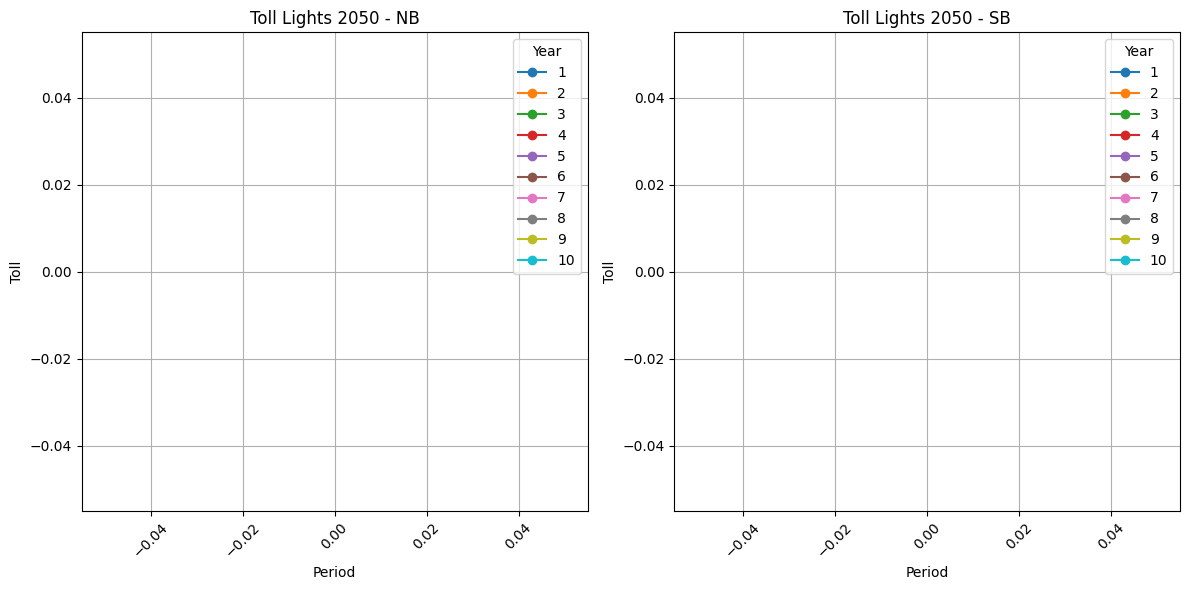

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar CSV
# model_run = pd.read_csv("outputs\\2025-09-02\\19-01-04_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

year_val = 2050

model_run = model_run.loc[model_run["Year"] == year_val]

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5

# 2. Definir años y direcciones
segments = [1,2,3,4,5,6,7,8,9,10]
directions = ["NB", "SB"]

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    for segment in segments:
        df = model_run[(model_run["Segment"] == segment) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(segment))
        
    
    plt.title(f"Toll Lights {year_val} - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (8,)

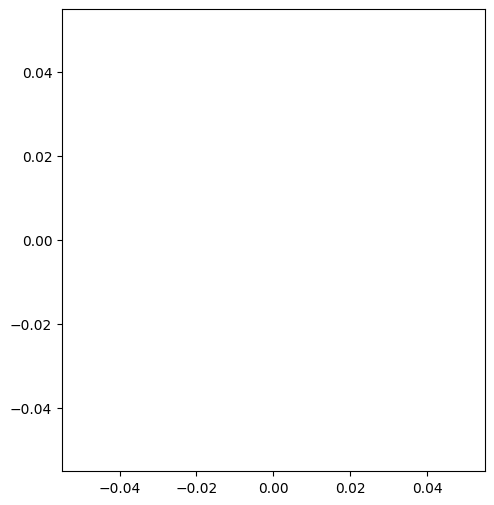

In [170]:
import pandas as pd
import matplotlib.pyplot as plt

# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-11\\total_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv(f"outputs\\2025-10-08\\test_new_cap_v3\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-15\\cap_categories_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-18\\15-26-30_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

# model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

years = [2032, 2040, 2050]
directions = ["NB", "SB"]

model_run = model_run.loc[model_run["Segment"] == 2] #2

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5
model_run.loc[model_run['Period'] == 'PM-Late', 'TollLights'] = 0.5

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
        
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        #if year == 2050:
        #    df["TollLights"] = df["TollLights"].clip(upper=5.15)
        #if year == 2040:
        #    df["TollLights"] = df["TollLights"].clip(upper=4.2)
        #if year == 2032:
        #    df["TollLights"] = df["TollLights"].clip(upper=3.6)

        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(year))   
    
    
    df_cap_50 = pd.DataFrame({"Value": [5.15] * 8})
    df_cap_40 = pd.DataFrame({"Value": [4.2] * 8})
    df_cap_32 = pd.DataFrame({"Value": [3.6] * 8})
    plt.plot(df["Period"], df_cap_50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_32["Value"], marker='o', linestyle='--', color='blue')
    df_cap_s50 = pd.DataFrame({"Value": [5.15/2] * 8})
    df_cap_s40 = pd.DataFrame({"Value": [4.2/2] * 8})
    df_cap_s32 = pd.DataFrame({"Value": [3.6/2] * 8})
    plt.plot(df["Period"], df_cap_s50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_s40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_s32["Value"], marker='o', linestyle='--', color='blue') 

    plt.title(f"Toll Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

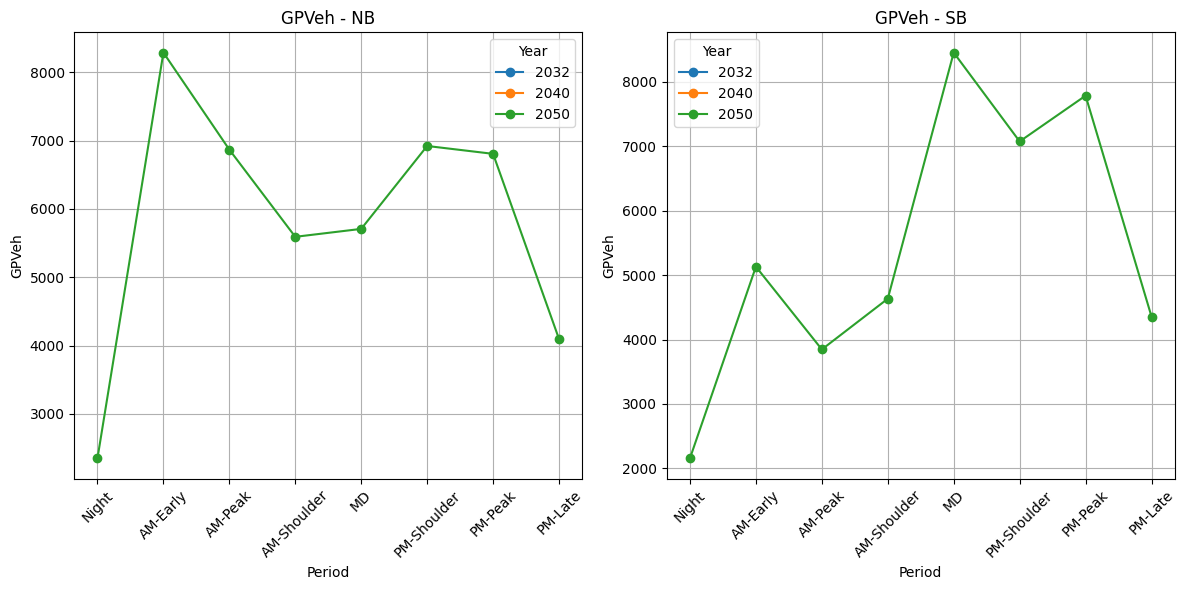

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["GPVeh"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"GPVeh - {direction}")
    plt.xlabel("Period")
    plt.ylabel("GPVeh")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

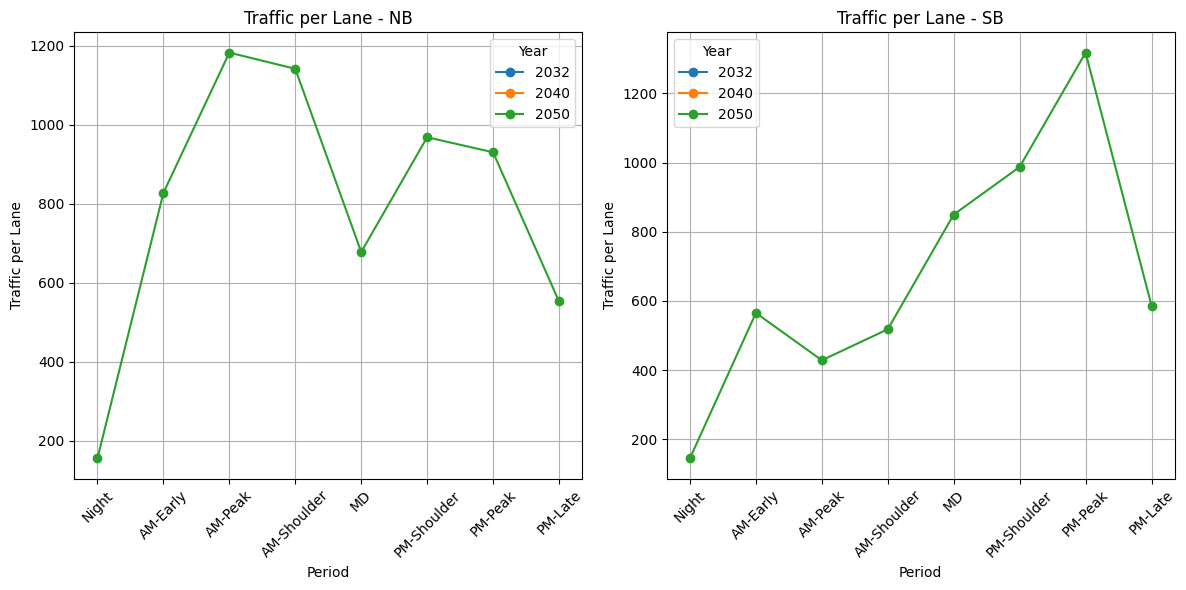

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["ML PCE"] / 2, marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Traffic per Lane - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Traffic per Lane")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

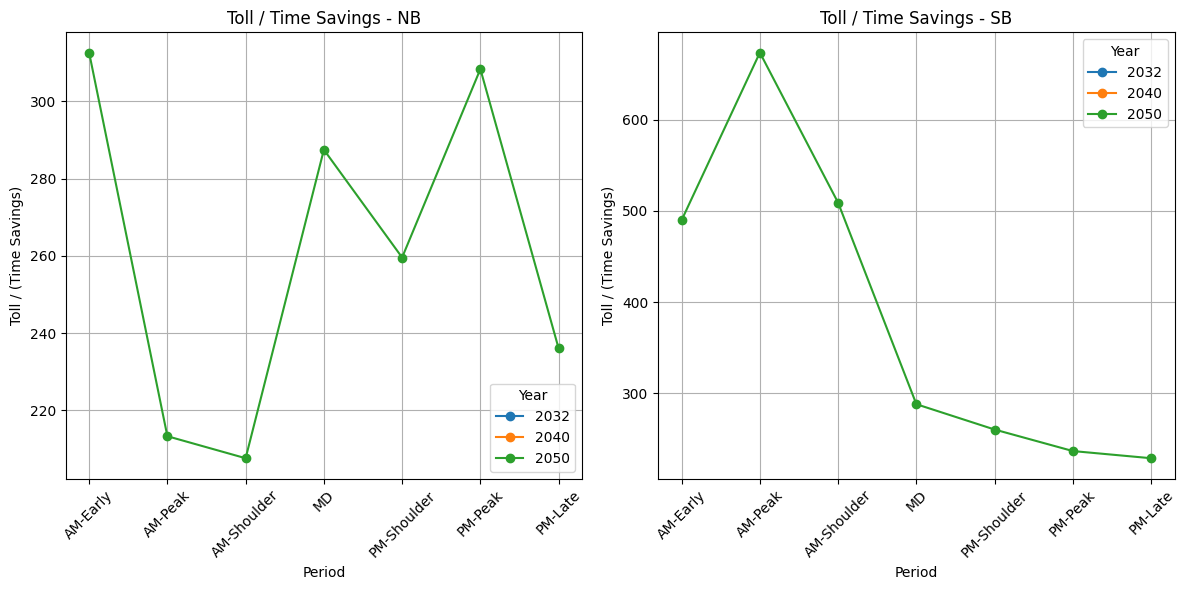

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != 'Night')]
        plt.plot(df["Period"], (60 * df["TollLights"] / (df["Time GP"] - df["Time ML"])), marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Toll / Time Savings - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll / (Time Savings)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

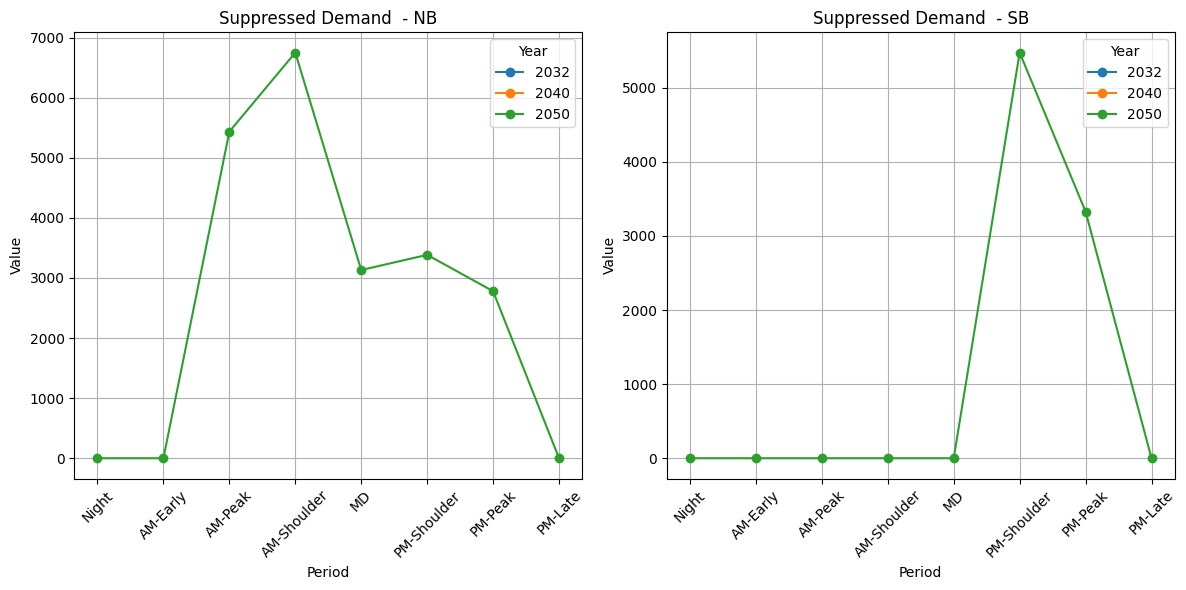

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Suppressed Demand"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Suppressed Demand  - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

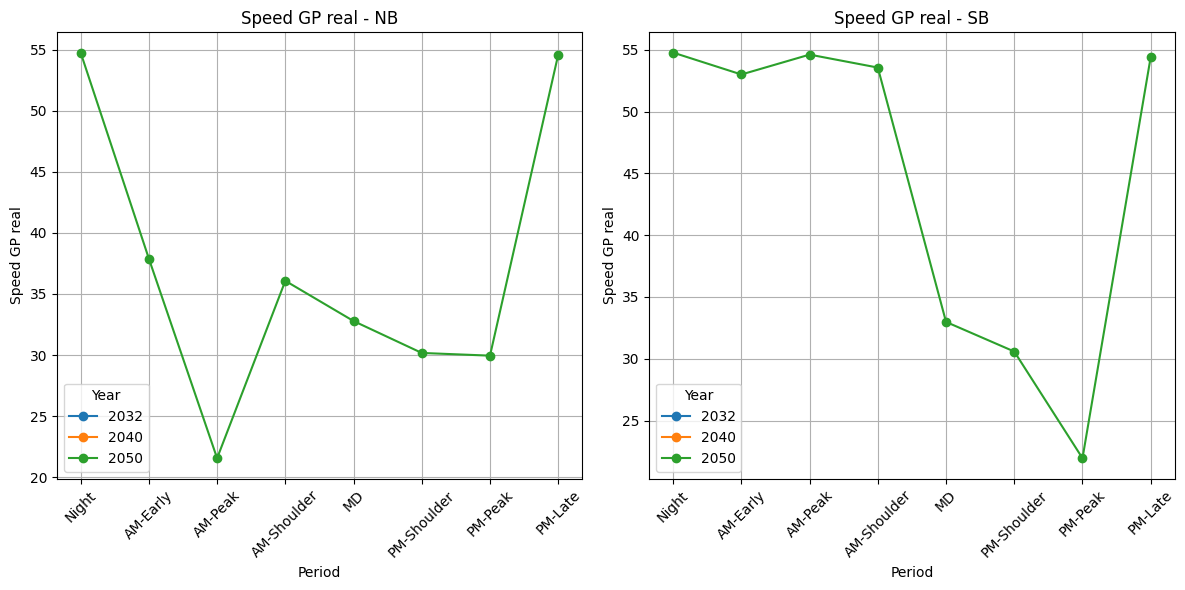

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed GP Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed GP real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed GP real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

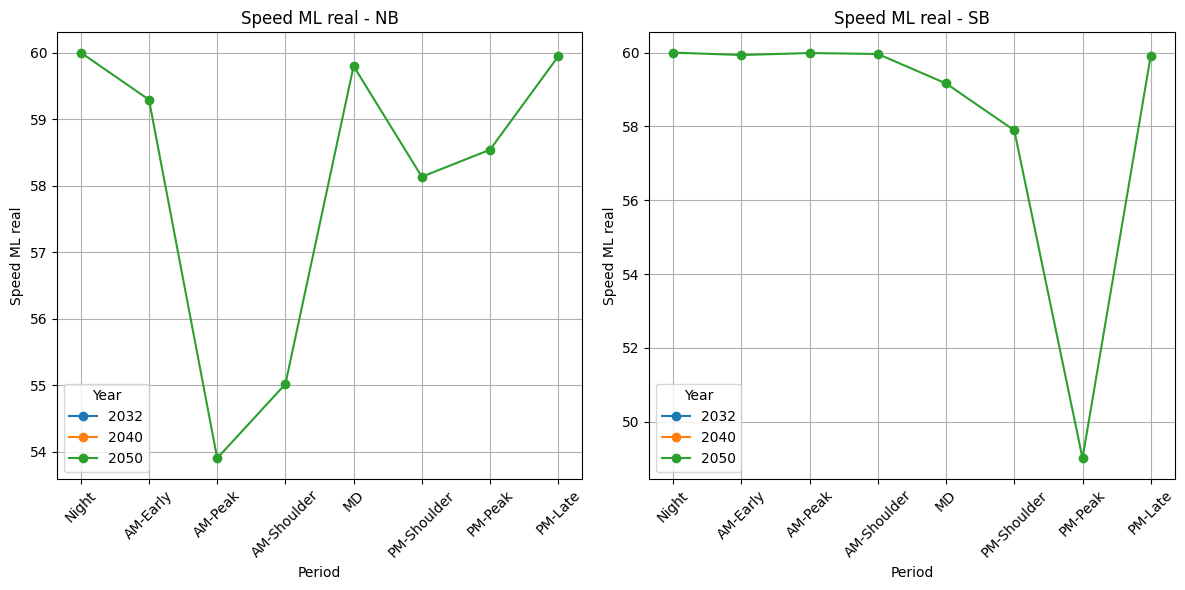

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed ML Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed ML real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed ML real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

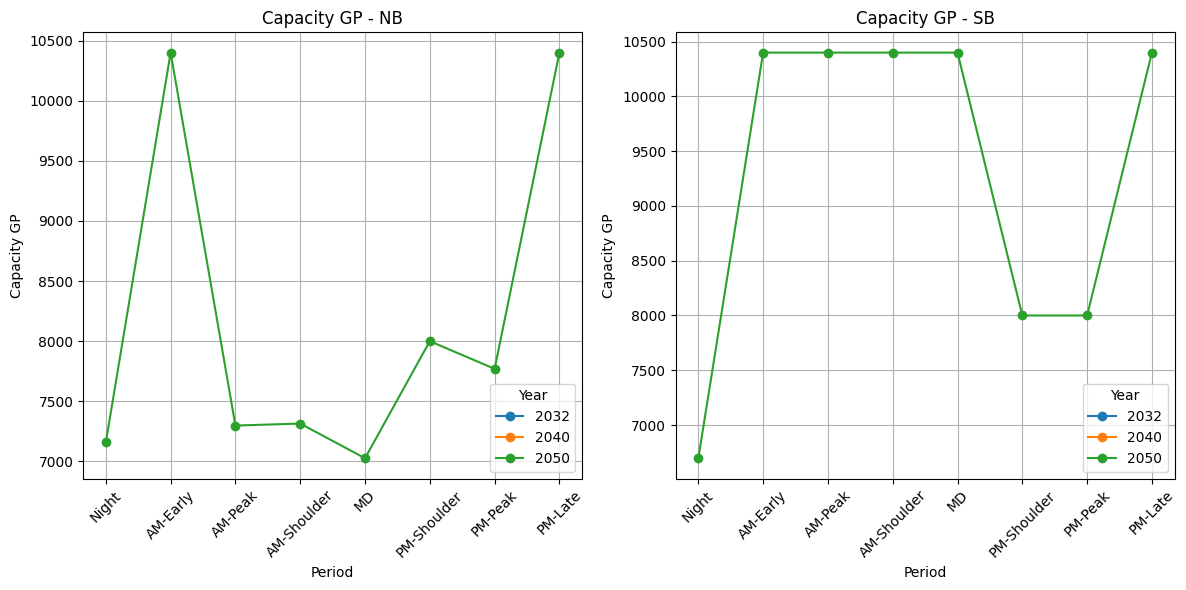

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Capacity GP"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Capacity GP - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Capacity GP")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

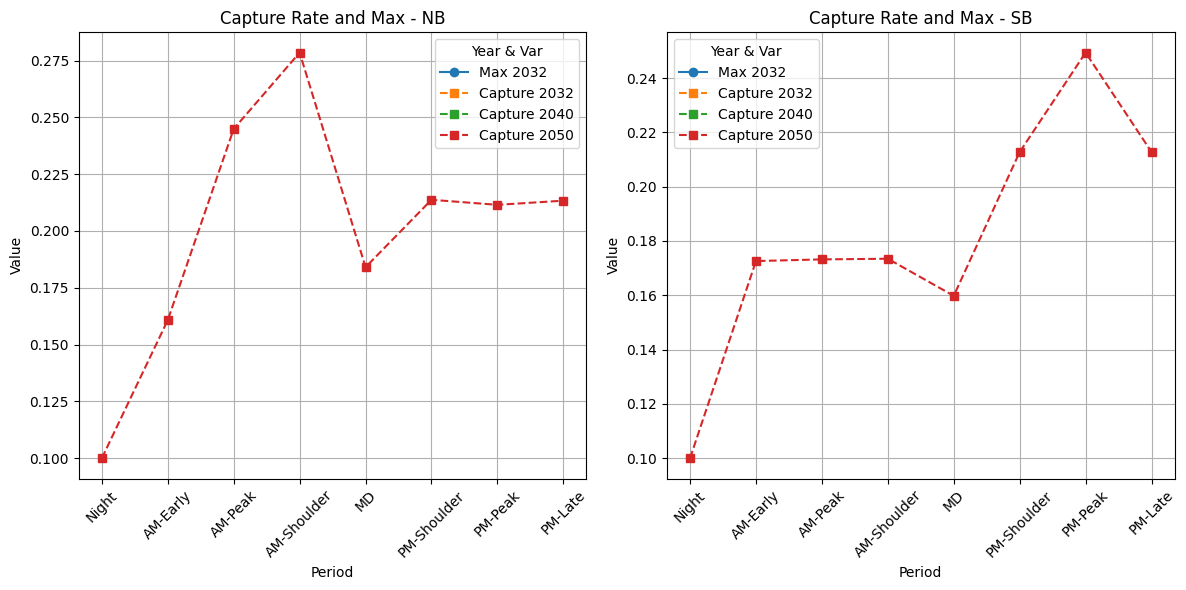

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        
        # Graficar Capture
        if year == years[0]:
            plt.plot(df["Period"], df["MaxCapture"], marker='o', linestyle='-', label=f"Max {year}")
        # Graficar Toll
        plt.plot(df["Period"], df["CaptureRateLights"], marker='s', linestyle='--', label=f"Capture {year}")
    
    plt.title(f"Capture Rate and Max - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year & Var")

plt.tight_layout()
plt.show()


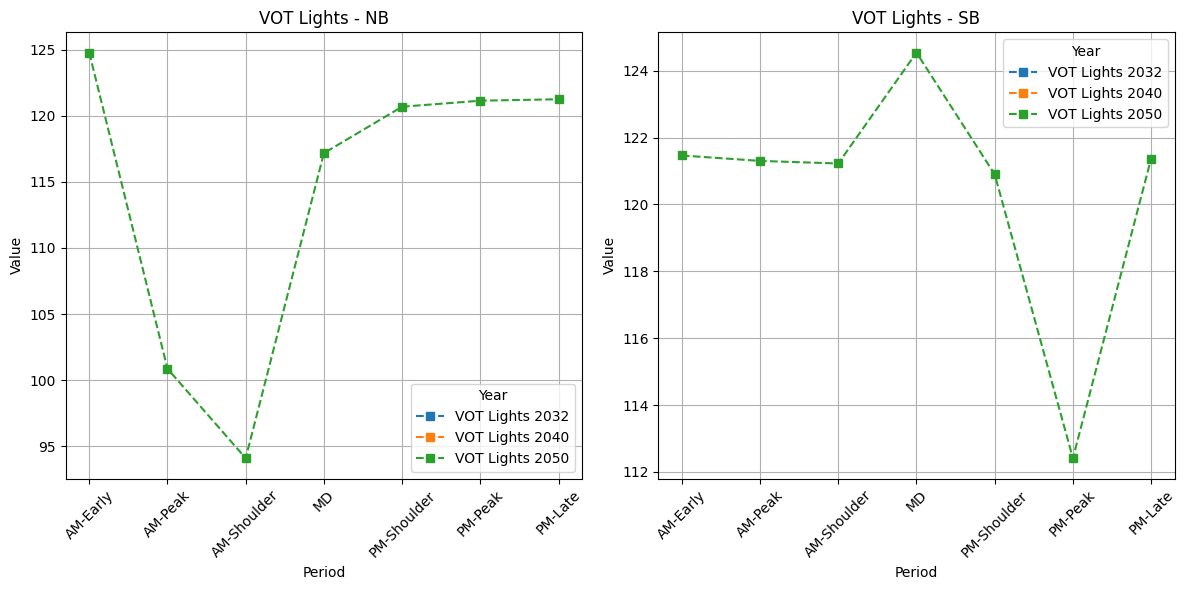

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != "Night")]

        # Graficar Toll
        plt.plot(df["Period"], df["VOT Lights"], marker='s', linestyle='--', label=f"VOT Lights {year}")
    
    plt.title(f"VOT Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()
